In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 831)
(3944610, 8)
validation
(464344, 831)
(464344, 8)
test
(574820, 831)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

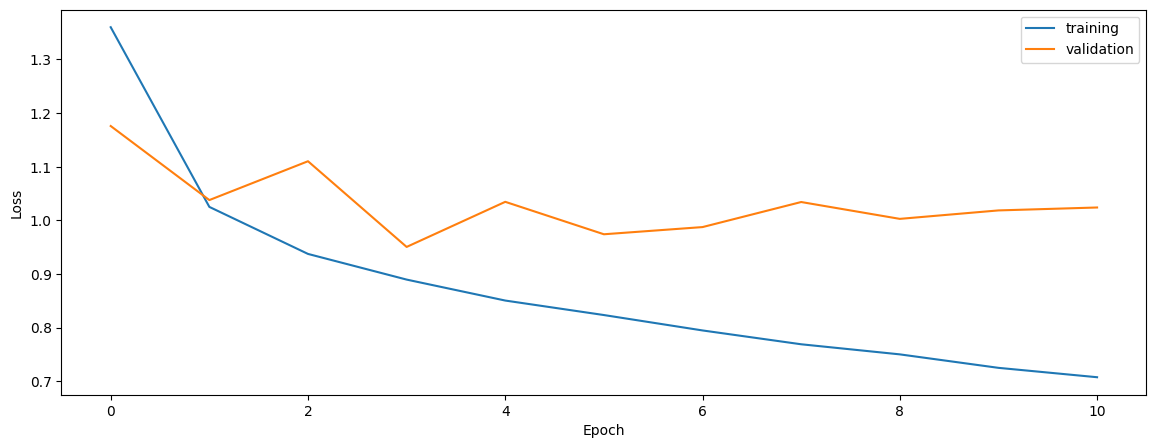

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_coords_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 831)
(1068345, 1)
validation
(123115, 831)
(123115, 1)
test
(152076, 831)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 831)]             0         


 dense_5 (Dense)             (None, 1024)              851968    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/107 [..............................] - ETA: 2:42 - loss: 0.2733 - STD: 2.0868e-04 - MAE: 0.4979

  4/107 [>.............................] - ETA: 2s - loss: 0.2447 - STD: 5.0817e-04 - MAE: 0.4454  

  7/107 [>.............................] - ETA: 2s - loss: 0.2361 - STD: 7.2231e-04 - MAE: 0.4390

 10/107 [=>............................] - ETA: 2s - loss: 0.2328 - STD: 9.9091e-04 - MAE: 0.4466

 13/107 [==>...........................] - ETA: 2s - loss: 0.2299 - STD: 0.0012 - MAE: 0.4487    

 16/107 [===>..........................] - ETA: 7s - loss: 0.2277 - STD: 0.0014 - MAE: 0.4457

 19/107 [====>.........................] - ETA: 6s - loss: 0.2265 - STD: 0.0016 - MAE: 0.4432

 22/107 [=====>........................] - ETA: 5s - loss: 0.2253 - STD: 0.0019 - MAE: 0.4430

 25/107 [======>.......................] - ETA: 4s - loss: 0.2245 - STD: 0.0022 - MAE: 0.4443

 28/107 [======>.......................] - ETA: 4s - loss: 0.2237 - STD: 0.0026 - MAE: 0.4450

 31/107 [=======>......................] - ETA: 3s - loss: 0.2230 - STD: 0.0031 - MAE: 0.4444

 34/107 [========>.....................] - ETA: 3s - loss: 0.2225 - STD: 0.0036 - MAE: 0.4437

 37/107 [=========>....................] - ETA: 3s - loss: 0.2218 - STD: 0.0044 - MAE: 0.4434

 40/107 [==========>...................] - ETA: 2s - loss: 0.2212 - STD: 0.0054 - MAE: 0.4435

 43/107 [===========>..................] - ETA: 2s - loss: 0.2205 - STD: 0.0068 - MAE: 0.4432

 46/107 [===========>..................] - ETA: 2s - loss: 0.2198 - STD: 0.0086 - MAE: 0.4423

 49/107 [============>.................] - ETA: 2s - loss: 0.2191 - STD: 0.0110 - MAE: 0.4415

 52/107 [=============>................] - ETA: 2s - loss: 0.2183 - STD: 0.0144 - MAE: 0.4407

 55/107 [==============>...............] - ETA: 2s - loss: 0.2174 - STD: 0.0183 - MAE: 0.4394

 58/107 [===============>..............] - ETA: 1s - loss: 0.2164 - STD: 0.0226 - MAE: 0.4378

 61/107 [================>.............] - ETA: 1s - loss: 0.2154 - STD: 0.0275 - MAE: 0.4362

 64/107 [================>.............] - ETA: 1s - loss: 0.2145 - STD: 0.0321 - MAE: 0.4346

 67/107 [=================>............] - ETA: 1s - loss: 0.2136 - STD: 0.0365 - MAE: 0.4331

 70/107 [==================>...........] - ETA: 1s - loss: 0.2128 - STD: 0.0408 - MAE: 0.4317

 73/107 [===================>..........] - ETA: 1s - loss: 0.2120 - STD: 0.0451 - MAE: 0.4302

 76/107 [====================>.........] - ETA: 1s - loss: 0.2113 - STD: 0.0490 - MAE: 0.4287

 79/107 [=====================>........] - ETA: 0s - loss: 0.2105 - STD: 0.0531 - MAE: 0.4273

 82/107 [=====================>........] - ETA: 0s - loss: 0.2098 - STD: 0.0567 - MAE: 0.4260

 85/107 [======================>.......] - ETA: 0s - loss: 0.2092 - STD: 0.0599 - MAE: 0.4249

 88/107 [=======================>......] - ETA: 0s - loss: 0.2086 - STD: 0.0631 - MAE: 0.4237

 91/107 [========================>.....] - ETA: 0s - loss: 0.2080 - STD: 0.0661 - MAE: 0.4226

 94/107 [=========================>....] - ETA: 0s - loss: 0.2075 - STD: 0.0693 - MAE: 0.4215

 97/107 [==========================>...] - ETA: 0s - loss: 0.2070 - STD: 0.0720 - MAE: 0.4205

100/107 [===========================>..] - ETA: 0s - loss: 0.2064 - STD: 0.0746 - MAE: 0.4195

103/107 [===========================>..] - ETA: 0s - loss: 0.2060 - STD: 0.0769 - MAE: 0.4186

106/107 [============================>.] - ETA: 0s - loss: 0.2055 - STD: 0.0791 - MAE: 0.4178

107/107 [==============================] - 6s 38ms/step - loss: 0.2054 - STD: 0.0799 - MAE: 0.4175 - val_loss: 0.1904 - val_STD: 0.1440 - val_MAE: 0.3904


Epoch 2/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1919 - STD: 0.1660 - MAE: 0.3897

  4/107 [>.............................] - ETA: 2s - loss: 0.1898 - STD: 0.1562 - MAE: 0.3874

  7/107 [>.............................] - ETA: 2s - loss: 0.1902 - STD: 0.1580 - MAE: 0.3883

 10/107 [=>............................] - ETA: 2s - loss: 0.1901 - STD: 0.1569 - MAE: 0.3883

 13/107 [==>...........................] - ETA: 2s - loss: 0.1898 - STD: 0.1584 - MAE: 0.3878

 16/107 [===>..........................] - ETA: 2s - loss: 0.1899 - STD: 0.1581 - MAE: 0.3879

 19/107 [====>.........................] - ETA: 1s - loss: 0.1898 - STD: 0.1581 - MAE: 0.3880

 22/107 [=====>........................] - ETA: 1s - loss: 0.1897 - STD: 0.1581 - MAE: 0.3880

 25/107 [======>.......................] - ETA: 1s - loss: 0.1896 - STD: 0.1579 - MAE: 0.3879

 28/107 [======>.......................] - ETA: 1s - loss: 0.1892 - STD: 0.1578 - MAE: 0.3874

 31/107 [=======>......................] - ETA: 1s - loss: 0.1891 - STD: 0.1587 - MAE: 0.3871

 34/107 [========>.....................] - ETA: 1s - loss: 0.1890 - STD: 0.1584 - MAE: 0.3869

 37/107 [=========>....................] - ETA: 1s - loss: 0.1887 - STD: 0.1584 - MAE: 0.3867

 40/107 [==========>...................] - ETA: 1s - loss: 0.1883 - STD: 0.1588 - MAE: 0.3863

 43/107 [===========>..................] - ETA: 1s - loss: 0.1880 - STD: 0.1595 - MAE: 0.3857

 46/107 [===========>..................] - ETA: 1s - loss: 0.1876 - STD: 0.1601 - MAE: 0.3851

 49/107 [============>.................] - ETA: 1s - loss: 0.1873 - STD: 0.1608 - MAE: 0.3844

 52/107 [=============>................] - ETA: 1s - loss: 0.1870 - STD: 0.1623 - MAE: 0.3837

 55/107 [==============>...............] - ETA: 1s - loss: 0.1866 - STD: 0.1638 - MAE: 0.3829

 58/107 [===============>..............] - ETA: 1s - loss: 0.1863 - STD: 0.1650 - MAE: 0.3822

 61/107 [================>.............] - ETA: 1s - loss: 0.1859 - STD: 0.1660 - MAE: 0.3815

 64/107 [================>.............] - ETA: 0s - loss: 0.1857 - STD: 0.1670 - MAE: 0.3809

 67/107 [=================>............] - ETA: 0s - loss: 0.1853 - STD: 0.1680 - MAE: 0.3804

 70/107 [==================>...........] - ETA: 0s - loss: 0.1850 - STD: 0.1689 - MAE: 0.3797

 73/107 [===================>..........] - ETA: 0s - loss: 0.1846 - STD: 0.1698 - MAE: 0.3791

 76/107 [====================>.........] - ETA: 0s - loss: 0.1843 - STD: 0.1708 - MAE: 0.3786

 79/107 [=====================>........] - ETA: 0s - loss: 0.1840 - STD: 0.1716 - MAE: 0.3780

 82/107 [=====================>........] - ETA: 0s - loss: 0.1836 - STD: 0.1726 - MAE: 0.3774

 85/107 [======================>.......] - ETA: 0s - loss: 0.1834 - STD: 0.1737 - MAE: 0.3768

 88/107 [=======================>......] - ETA: 0s - loss: 0.1831 - STD: 0.1747 - MAE: 0.3763

 91/107 [========================>.....] - ETA: 0s - loss: 0.1829 - STD: 0.1755 - MAE: 0.3758

 94/107 [=========================>....] - ETA: 0s - loss: 0.1826 - STD: 0.1762 - MAE: 0.3753

 97/107 [==========================>...] - ETA: 0s - loss: 0.1823 - STD: 0.1769 - MAE: 0.3749

100/107 [===========================>..] - ETA: 0s - loss: 0.1820 - STD: 0.1776 - MAE: 0.3743

103/107 [===========================>..] - ETA: 0s - loss: 0.1818 - STD: 0.1784 - MAE: 0.3738

106/107 [============================>.] - ETA: 0s - loss: 0.1816 - STD: 0.1792 - MAE: 0.3733

107/107 [==============================] - 3s 25ms/step - loss: 0.1815 - STD: 0.1794 - MAE: 0.3732 - val_loss: 0.1685 - val_STD: 0.1752 - val_MAE: 0.3542


Epoch 3/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1750 - STD: 0.2033 - MAE: 0.3615

  4/107 [>.............................] - ETA: 2s - loss: 0.1744 - STD: 0.2045 - MAE: 0.3603

  7/107 [>.............................] - ETA: 2s - loss: 0.1732 - STD: 0.2041 - MAE: 0.3587

 10/107 [=>............................] - ETA: 2s - loss: 0.1732 - STD: 0.2055 - MAE: 0.3582

 13/107 [==>...........................] - ETA: 2s - loss: 0.1736 - STD: 0.2058 - MAE: 0.3577

 16/107 [===>..........................] - ETA: 2s - loss: 0.1736 - STD: 0.2055 - MAE: 0.3571

 19/107 [====>.........................] - ETA: 1s - loss: 0.1733 - STD: 0.2048 - MAE: 0.3569

 22/107 [=====>........................] - ETA: 1s - loss: 0.1732 - STD: 0.2041 - MAE: 0.3571

 25/107 [======>.......................] - ETA: 1s - loss: 0.1731 - STD: 0.2039 - MAE: 0.3573

 28/107 [======>.......................] - ETA: 1s - loss: 0.1731 - STD: 0.2042 - MAE: 0.3572

 31/107 [=======>......................] - ETA: 1s - loss: 0.1728 - STD: 0.2047 - MAE: 0.3568

 34/107 [========>.....................] - ETA: 1s - loss: 0.1727 - STD: 0.2053 - MAE: 0.3565

 37/107 [=========>....................] - ETA: 1s - loss: 0.1726 - STD: 0.2059 - MAE: 0.3562

 40/107 [==========>...................] - ETA: 1s - loss: 0.1726 - STD: 0.2060 - MAE: 0.3562

 43/107 [===========>..................] - ETA: 1s - loss: 0.1725 - STD: 0.2062 - MAE: 0.3559

 46/107 [===========>..................] - ETA: 1s - loss: 0.1723 - STD: 0.2064 - MAE: 0.3557

 49/107 [============>.................] - ETA: 1s - loss: 0.1723 - STD: 0.2065 - MAE: 0.3557

 52/107 [=============>................] - ETA: 1s - loss: 0.1722 - STD: 0.2063 - MAE: 0.3556

 55/107 [==============>...............] - ETA: 1s - loss: 0.1721 - STD: 0.2064 - MAE: 0.3554

 58/107 [===============>..............] - ETA: 1s - loss: 0.1721 - STD: 0.2066 - MAE: 0.3552

 61/107 [================>.............] - ETA: 1s - loss: 0.1720 - STD: 0.2067 - MAE: 0.3551

 64/107 [================>.............] - ETA: 0s - loss: 0.1719 - STD: 0.2068 - MAE: 0.3550

 67/107 [=================>............] - ETA: 0s - loss: 0.1717 - STD: 0.2070 - MAE: 0.3548

 70/107 [==================>...........] - ETA: 0s - loss: 0.1715 - STD: 0.2074 - MAE: 0.3545

 73/107 [===================>..........] - ETA: 0s - loss: 0.1714 - STD: 0.2078 - MAE: 0.3542

 76/107 [====================>.........] - ETA: 0s - loss: 0.1712 - STD: 0.2083 - MAE: 0.3539

 79/107 [=====================>........] - ETA: 0s - loss: 0.1711 - STD: 0.2087 - MAE: 0.3536

 82/107 [=====================>........] - ETA: 0s - loss: 0.1709 - STD: 0.2090 - MAE: 0.3534

 85/107 [======================>.......] - ETA: 0s - loss: 0.1707 - STD: 0.2094 - MAE: 0.3530

 88/107 [=======================>......] - ETA: 0s - loss: 0.1707 - STD: 0.2097 - MAE: 0.3529

 91/107 [========================>.....] - ETA: 0s - loss: 0.1708 - STD: 0.2098 - MAE: 0.3528

 94/107 [=========================>....] - ETA: 0s - loss: 0.1710 - STD: 0.2098 - MAE: 0.3528

 97/107 [==========================>...] - ETA: 0s - loss: 0.1713 - STD: 0.2097 - MAE: 0.3531

100/107 [===========================>..] - ETA: 0s - loss: 0.1715 - STD: 0.2092 - MAE: 0.3531

103/107 [===========================>..] - ETA: 0s - loss: 0.1715 - STD: 0.2086 - MAE: 0.3534

106/107 [============================>.] - ETA: 0s - loss: 0.1716 - STD: 0.2080 - MAE: 0.3537

107/107 [==============================] - 3s 25ms/step - loss: 0.1716 - STD: 0.2078 - MAE: 0.3538 - val_loss: 0.1677 - val_STD: 0.1593 - val_MAE: 0.3497


Epoch 4/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1720 - STD: 0.1875 - MAE: 0.3546

  4/107 [>.............................] - ETA: 2s - loss: 0.1717 - STD: 0.1989 - MAE: 0.3557

  7/107 [>.............................] - ETA: 2s - loss: 0.1698 - STD: 0.2030 - MAE: 0.3519

 10/107 [=>............................] - ETA: 2s - loss: 0.1690 - STD: 0.2076 - MAE: 0.3508

 13/107 [==>...........................] - ETA: 2s - loss: 0.1686 - STD: 0.2109 - MAE: 0.3491

 16/107 [===>..........................] - ETA: 2s - loss: 0.1684 - STD: 0.2132 - MAE: 0.3480

 19/107 [====>.........................] - ETA: 1s - loss: 0.1683 - STD: 0.2156 - MAE: 0.3473

 22/107 [=====>........................] - ETA: 1s - loss: 0.1679 - STD: 0.2173 - MAE: 0.3466

 25/107 [======>.......................] - ETA: 1s - loss: 0.1677 - STD: 0.2180 - MAE: 0.3464

 28/107 [======>.......................] - ETA: 1s - loss: 0.1674 - STD: 0.2181 - MAE: 0.3460

 31/107 [=======>......................] - ETA: 1s - loss: 0.1672 - STD: 0.2179 - MAE: 0.3461

 34/107 [========>.....................] - ETA: 1s - loss: 0.1670 - STD: 0.2180 - MAE: 0.3461

 37/107 [=========>....................] - ETA: 1s - loss: 0.1670 - STD: 0.2182 - MAE: 0.3460

 40/107 [==========>...................] - ETA: 1s - loss: 0.1668 - STD: 0.2185 - MAE: 0.3457

 43/107 [===========>..................] - ETA: 1s - loss: 0.1667 - STD: 0.2190 - MAE: 0.3455

 46/107 [===========>..................] - ETA: 1s - loss: 0.1664 - STD: 0.2194 - MAE: 0.3452

 49/107 [============>.................] - ETA: 1s - loss: 0.1664 - STD: 0.2198 - MAE: 0.3449

 52/107 [=============>................] - ETA: 1s - loss: 0.1663 - STD: 0.2203 - MAE: 0.3447

 55/107 [==============>...............] - ETA: 1s - loss: 0.1662 - STD: 0.2208 - MAE: 0.3444

 58/107 [===============>..............] - ETA: 1s - loss: 0.1662 - STD: 0.2210 - MAE: 0.3444

 61/107 [================>.............] - ETA: 1s - loss: 0.1660 - STD: 0.2211 - MAE: 0.3442

 64/107 [================>.............] - ETA: 0s - loss: 0.1660 - STD: 0.2213 - MAE: 0.3442

 67/107 [=================>............] - ETA: 0s - loss: 0.1660 - STD: 0.2216 - MAE: 0.3441

 70/107 [==================>...........] - ETA: 0s - loss: 0.1659 - STD: 0.2218 - MAE: 0.3439

 73/107 [===================>..........] - ETA: 0s - loss: 0.1658 - STD: 0.2219 - MAE: 0.3438

 76/107 [====================>.........] - ETA: 0s - loss: 0.1658 - STD: 0.2220 - MAE: 0.3437

 79/107 [=====================>........] - ETA: 0s - loss: 0.1658 - STD: 0.2221 - MAE: 0.3437

 82/107 [=====================>........] - ETA: 0s - loss: 0.1660 - STD: 0.2221 - MAE: 0.3438

 85/107 [======================>.......] - ETA: 0s - loss: 0.1662 - STD: 0.2219 - MAE: 0.3439

 88/107 [=======================>......] - ETA: 0s - loss: 0.1661 - STD: 0.2216 - MAE: 0.3438

 91/107 [========================>.....] - ETA: 0s - loss: 0.1661 - STD: 0.2213 - MAE: 0.3439

 94/107 [=========================>....] - ETA: 0s - loss: 0.1661 - STD: 0.2212 - MAE: 0.3440

 97/107 [==========================>...] - ETA: 0s - loss: 0.1660 - STD: 0.2213 - MAE: 0.3439

100/107 [===========================>..] - ETA: 0s - loss: 0.1659 - STD: 0.2214 - MAE: 0.3438

103/107 [===========================>..] - ETA: 0s - loss: 0.1659 - STD: 0.2214 - MAE: 0.3437

106/107 [============================>.] - ETA: 0s - loss: 0.1659 - STD: 0.2215 - MAE: 0.3436

107/107 [==============================] - 3s 25ms/step - loss: 0.1659 - STD: 0.2216 - MAE: 0.3436 - val_loss: 0.1584 - val_STD: 0.1970 - val_MAE: 0.3329


Epoch 5/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1688 - STD: 0.2280 - MAE: 0.3439

  4/107 [>.............................] - ETA: 2s - loss: 0.1656 - STD: 0.2299 - MAE: 0.3410

  7/107 [>.............................] - ETA: 2s - loss: 0.1640 - STD: 0.2287 - MAE: 0.3396

 10/107 [=>............................] - ETA: 2s - loss: 0.1639 - STD: 0.2276 - MAE: 0.3400

 13/107 [==>...........................] - ETA: 2s - loss: 0.1635 - STD: 0.2275 - MAE: 0.3396

 16/107 [===>..........................] - ETA: 2s - loss: 0.1631 - STD: 0.2276 - MAE: 0.3390

 19/107 [====>.........................] - ETA: 1s - loss: 0.1630 - STD: 0.2280 - MAE: 0.3388

 22/107 [=====>........................] - ETA: 1s - loss: 0.1630 - STD: 0.2287 - MAE: 0.3384

 25/107 [======>.......................] - ETA: 1s - loss: 0.1631 - STD: 0.2289 - MAE: 0.3381

 28/107 [======>.......................] - ETA: 1s - loss: 0.1633 - STD: 0.2288 - MAE: 0.3380

 31/107 [=======>......................] - ETA: 1s - loss: 0.1639 - STD: 0.2284 - MAE: 0.3384

 34/107 [========>.....................] - ETA: 1s - loss: 0.1640 - STD: 0.2282 - MAE: 0.3386

 37/107 [=========>....................] - ETA: 1s - loss: 0.1642 - STD: 0.2277 - MAE: 0.3390

 40/107 [==========>...................] - ETA: 1s - loss: 0.1641 - STD: 0.2270 - MAE: 0.3393

 43/107 [===========>..................] - ETA: 1s - loss: 0.1642 - STD: 0.2262 - MAE: 0.3396

 46/107 [===========>..................] - ETA: 1s - loss: 0.1640 - STD: 0.2259 - MAE: 0.3396

 49/107 [============>.................] - ETA: 1s - loss: 0.1638 - STD: 0.2261 - MAE: 0.3394

 52/107 [=============>................] - ETA: 1s - loss: 0.1637 - STD: 0.2265 - MAE: 0.3392

 55/107 [==============>...............] - ETA: 1s - loss: 0.1637 - STD: 0.2269 - MAE: 0.3392

 58/107 [===============>..............] - ETA: 1s - loss: 0.1636 - STD: 0.2272 - MAE: 0.3389

 61/107 [================>.............] - ETA: 1s - loss: 0.1634 - STD: 0.2276 - MAE: 0.3386

 64/107 [================>.............] - ETA: 0s - loss: 0.1633 - STD: 0.2280 - MAE: 0.3384

 67/107 [=================>............] - ETA: 0s - loss: 0.1632 - STD: 0.2282 - MAE: 0.3382

 70/107 [==================>...........] - ETA: 0s - loss: 0.1632 - STD: 0.2284 - MAE: 0.3382

 73/107 [===================>..........] - ETA: 0s - loss: 0.1632 - STD: 0.2287 - MAE: 0.3381

 76/107 [====================>.........] - ETA: 0s - loss: 0.1631 - STD: 0.2288 - MAE: 0.3379

 79/107 [=====================>........] - ETA: 0s - loss: 0.1630 - STD: 0.2288 - MAE: 0.3379

 82/107 [=====================>........] - ETA: 0s - loss: 0.1630 - STD: 0.2291 - MAE: 0.3378

 85/107 [======================>.......] - ETA: 0s - loss: 0.1629 - STD: 0.2293 - MAE: 0.3377

 88/107 [=======================>......] - ETA: 0s - loss: 0.1628 - STD: 0.2293 - MAE: 0.3375

 91/107 [========================>.....] - ETA: 0s - loss: 0.1628 - STD: 0.2295 - MAE: 0.3375

 94/107 [=========================>....] - ETA: 0s - loss: 0.1630 - STD: 0.2296 - MAE: 0.3375

 97/107 [==========================>...] - ETA: 0s - loss: 0.1633 - STD: 0.2293 - MAE: 0.3376

100/107 [===========================>..] - ETA: 0s - loss: 0.1634 - STD: 0.2291 - MAE: 0.3378

103/107 [===========================>..] - ETA: 0s - loss: 0.1634 - STD: 0.2287 - MAE: 0.3380

106/107 [============================>.] - ETA: 0s - loss: 0.1634 - STD: 0.2282 - MAE: 0.3381

107/107 [==============================] - 3s 25ms/step - loss: 0.1634 - STD: 0.2281 - MAE: 0.3382 - val_loss: 0.1576 - val_STD: 0.1873 - val_MAE: 0.3376


Epoch 6/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1648 - STD: 0.2167 - MAE: 0.3452

  4/107 [>.............................] - ETA: 2s - loss: 0.1620 - STD: 0.2177 - MAE: 0.3410

  7/107 [>.............................] - ETA: 2s - loss: 0.1616 - STD: 0.2207 - MAE: 0.3396

 10/107 [=>............................] - ETA: 2s - loss: 0.1613 - STD: 0.2239 - MAE: 0.3383

 13/107 [==>...........................] - ETA: 2s - loss: 0.1609 - STD: 0.2270 - MAE: 0.3368

 16/107 [===>..........................] - ETA: 2s - loss: 0.1609 - STD: 0.2292 - MAE: 0.3359

 19/107 [====>.........................] - ETA: 1s - loss: 0.1608 - STD: 0.2314 - MAE: 0.3349

 22/107 [=====>........................] - ETA: 1s - loss: 0.1607 - STD: 0.2327 - MAE: 0.3342

 25/107 [======>.......................] - ETA: 1s - loss: 0.1608 - STD: 0.2329 - MAE: 0.3342

 28/107 [======>.......................] - ETA: 1s - loss: 0.1609 - STD: 0.2335 - MAE: 0.3341

 31/107 [=======>......................] - ETA: 1s - loss: 0.1610 - STD: 0.2334 - MAE: 0.3343

 34/107 [========>.....................] - ETA: 1s - loss: 0.1609 - STD: 0.2333 - MAE: 0.3344

 37/107 [=========>....................] - ETA: 1s - loss: 0.1609 - STD: 0.2334 - MAE: 0.3344

 40/107 [==========>...................] - ETA: 1s - loss: 0.1610 - STD: 0.2335 - MAE: 0.3344

 43/107 [===========>..................] - ETA: 1s - loss: 0.1609 - STD: 0.2336 - MAE: 0.3345

 46/107 [===========>..................] - ETA: 1s - loss: 0.1609 - STD: 0.2336 - MAE: 0.3344

 49/107 [============>.................] - ETA: 1s - loss: 0.1606 - STD: 0.2340 - MAE: 0.3339

 52/107 [=============>................] - ETA: 1s - loss: 0.1605 - STD: 0.2345 - MAE: 0.3337

 55/107 [==============>...............] - ETA: 1s - loss: 0.1605 - STD: 0.2346 - MAE: 0.3337

 58/107 [===============>..............] - ETA: 1s - loss: 0.1604 - STD: 0.2348 - MAE: 0.3336

 61/107 [================>.............] - ETA: 1s - loss: 0.1604 - STD: 0.2350 - MAE: 0.3334

 64/107 [================>.............] - ETA: 0s - loss: 0.1604 - STD: 0.2351 - MAE: 0.3334

 67/107 [=================>............] - ETA: 0s - loss: 0.1605 - STD: 0.2352 - MAE: 0.3335

 70/107 [==================>...........] - ETA: 0s - loss: 0.1606 - STD: 0.2352 - MAE: 0.3334

 73/107 [===================>..........] - ETA: 0s - loss: 0.1608 - STD: 0.2350 - MAE: 0.3335

 76/107 [====================>.........] - ETA: 0s - loss: 0.1608 - STD: 0.2348 - MAE: 0.3336

 79/107 [=====================>........] - ETA: 0s - loss: 0.1608 - STD: 0.2345 - MAE: 0.3337

 82/107 [=====================>........] - ETA: 0s - loss: 0.1608 - STD: 0.2344 - MAE: 0.3338

 85/107 [======================>.......] - ETA: 0s - loss: 0.1608 - STD: 0.2343 - MAE: 0.3339

 88/107 [=======================>......] - ETA: 0s - loss: 0.1607 - STD: 0.2342 - MAE: 0.3338

 91/107 [========================>.....] - ETA: 0s - loss: 0.1606 - STD: 0.2343 - MAE: 0.3337

 94/107 [=========================>....] - ETA: 0s - loss: 0.1605 - STD: 0.2345 - MAE: 0.3335

 97/107 [==========================>...] - ETA: 0s - loss: 0.1604 - STD: 0.2348 - MAE: 0.3333

100/107 [===========================>..] - ETA: 0s - loss: 0.1604 - STD: 0.2350 - MAE: 0.3331

103/107 [===========================>..] - ETA: 0s - loss: 0.1603 - STD: 0.2353 - MAE: 0.3330

106/107 [============================>.] - ETA: 0s - loss: 0.1602 - STD: 0.2354 - MAE: 0.3328

107/107 [==============================] - 3s 25ms/step - loss: 0.1602 - STD: 0.2355 - MAE: 0.3328 - val_loss: 0.1544 - val_STD: 0.2059 - val_MAE: 0.3245


Epoch 7/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1576 - STD: 0.2361 - MAE: 0.3279

  4/107 [>.............................] - ETA: 2s - loss: 0.1584 - STD: 0.2395 - MAE: 0.3286

  7/107 [>.............................] - ETA: 2s - loss: 0.1587 - STD: 0.2403 - MAE: 0.3288

 10/107 [=>............................] - ETA: 2s - loss: 0.1586 - STD: 0.2400 - MAE: 0.3292

 13/107 [==>...........................] - ETA: 2s - loss: 0.1593 - STD: 0.2397 - MAE: 0.3299

 16/107 [===>..........................] - ETA: 2s - loss: 0.1601 - STD: 0.2387 - MAE: 0.3306

 19/107 [====>.........................] - ETA: 1s - loss: 0.1615 - STD: 0.2374 - MAE: 0.3317

 22/107 [=====>........................] - ETA: 1s - loss: 0.1623 - STD: 0.2367 - MAE: 0.3324

 25/107 [======>.......................] - ETA: 1s - loss: 0.1627 - STD: 0.2356 - MAE: 0.3331

 28/107 [======>.......................] - ETA: 1s - loss: 0.1627 - STD: 0.2333 - MAE: 0.3338

 31/107 [=======>......................] - ETA: 1s - loss: 0.1627 - STD: 0.2314 - MAE: 0.3347

 34/107 [========>.....................] - ETA: 1s - loss: 0.1624 - STD: 0.2309 - MAE: 0.3349

 37/107 [=========>....................] - ETA: 1s - loss: 0.1621 - STD: 0.2307 - MAE: 0.3348

 40/107 [==========>...................] - ETA: 1s - loss: 0.1619 - STD: 0.2308 - MAE: 0.3347

 43/107 [===========>..................] - ETA: 1s - loss: 0.1618 - STD: 0.2312 - MAE: 0.3344

 46/107 [===========>..................] - ETA: 1s - loss: 0.1616 - STD: 0.2320 - MAE: 0.3341

 49/107 [============>.................] - ETA: 1s - loss: 0.1614 - STD: 0.2329 - MAE: 0.3337

 52/107 [=============>................] - ETA: 1s - loss: 0.1613 - STD: 0.2334 - MAE: 0.3335

 55/107 [==============>...............] - ETA: 1s - loss: 0.1612 - STD: 0.2338 - MAE: 0.3333

 58/107 [===============>..............] - ETA: 1s - loss: 0.1610 - STD: 0.2341 - MAE: 0.3330

 61/107 [================>.............] - ETA: 1s - loss: 0.1607 - STD: 0.2344 - MAE: 0.3326

 64/107 [================>.............] - ETA: 0s - loss: 0.1607 - STD: 0.2346 - MAE: 0.3326

 67/107 [=================>............] - ETA: 0s - loss: 0.1605 - STD: 0.2350 - MAE: 0.3324

 70/107 [==================>...........] - ETA: 0s - loss: 0.1604 - STD: 0.2352 - MAE: 0.3322

 73/107 [===================>..........] - ETA: 0s - loss: 0.1603 - STD: 0.2354 - MAE: 0.3321

 76/107 [====================>.........] - ETA: 0s - loss: 0.1603 - STD: 0.2357 - MAE: 0.3320

 79/107 [=====================>........] - ETA: 0s - loss: 0.1601 - STD: 0.2358 - MAE: 0.3318

 82/107 [=====================>........] - ETA: 0s - loss: 0.1600 - STD: 0.2361 - MAE: 0.3316

 85/107 [======================>.......] - ETA: 0s - loss: 0.1599 - STD: 0.2364 - MAE: 0.3314

 88/107 [=======================>......] - ETA: 0s - loss: 0.1597 - STD: 0.2366 - MAE: 0.3312

 91/107 [========================>.....] - ETA: 0s - loss: 0.1597 - STD: 0.2369 - MAE: 0.3311

 94/107 [=========================>....] - ETA: 0s - loss: 0.1597 - STD: 0.2372 - MAE: 0.3310

 97/107 [==========================>...] - ETA: 0s - loss: 0.1597 - STD: 0.2372 - MAE: 0.3309

100/107 [===========================>..] - ETA: 0s - loss: 0.1598 - STD: 0.2372 - MAE: 0.3309

103/107 [===========================>..] - ETA: 0s - loss: 0.1600 - STD: 0.2372 - MAE: 0.3310

106/107 [============================>.] - ETA: 0s - loss: 0.1600 - STD: 0.2371 - MAE: 0.3311

107/107 [==============================] - 3s 24ms/step - loss: 0.1601 - STD: 0.2369 - MAE: 0.3312 - val_loss: 0.1564 - val_STD: 0.1847 - val_MAE: 0.3286


Epoch 8/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1567 - STD: 0.2192 - MAE: 0.3288

  4/107 [>.............................] - ETA: 2s - loss: 0.1609 - STD: 0.2260 - MAE: 0.3364

  7/107 [>.............................] - ETA: 2s - loss: 0.1605 - STD: 0.2281 - MAE: 0.3363

 10/107 [=>............................] - ETA: 2s - loss: 0.1605 - STD: 0.2284 - MAE: 0.3359

 13/107 [==>...........................] - ETA: 2s - loss: 0.1600 - STD: 0.2283 - MAE: 0.3347

 16/107 [===>..........................] - ETA: 2s - loss: 0.1601 - STD: 0.2296 - MAE: 0.3342

 19/107 [====>.........................] - ETA: 1s - loss: 0.1596 - STD: 0.2318 - MAE: 0.3332

 22/107 [=====>........................] - ETA: 1s - loss: 0.1594 - STD: 0.2334 - MAE: 0.3324

 25/107 [======>.......................] - ETA: 1s - loss: 0.1590 - STD: 0.2345 - MAE: 0.3314

 28/107 [======>.......................] - ETA: 1s - loss: 0.1586 - STD: 0.2353 - MAE: 0.3307

 31/107 [=======>......................] - ETA: 1s - loss: 0.1585 - STD: 0.2360 - MAE: 0.3303

 34/107 [========>.....................] - ETA: 1s - loss: 0.1585 - STD: 0.2367 - MAE: 0.3302

 37/107 [=========>....................] - ETA: 1s - loss: 0.1585 - STD: 0.2374 - MAE: 0.3300

 40/107 [==========>...................] - ETA: 1s - loss: 0.1584 - STD: 0.2376 - MAE: 0.3299

 43/107 [===========>..................] - ETA: 1s - loss: 0.1583 - STD: 0.2377 - MAE: 0.3297

 46/107 [===========>..................] - ETA: 1s - loss: 0.1584 - STD: 0.2381 - MAE: 0.3297

 49/107 [============>.................] - ETA: 1s - loss: 0.1582 - STD: 0.2383 - MAE: 0.3296

 52/107 [=============>................] - ETA: 1s - loss: 0.1582 - STD: 0.2386 - MAE: 0.3294

 55/107 [==============>...............] - ETA: 1s - loss: 0.1581 - STD: 0.2390 - MAE: 0.3293

 58/107 [===============>..............] - ETA: 1s - loss: 0.1579 - STD: 0.2392 - MAE: 0.3290

 61/107 [================>.............] - ETA: 1s - loss: 0.1578 - STD: 0.2393 - MAE: 0.3288

 64/107 [================>.............] - ETA: 0s - loss: 0.1577 - STD: 0.2397 - MAE: 0.3285

 67/107 [=================>............] - ETA: 0s - loss: 0.1576 - STD: 0.2402 - MAE: 0.3283

 70/107 [==================>...........] - ETA: 0s - loss: 0.1577 - STD: 0.2404 - MAE: 0.3283

 73/107 [===================>..........] - ETA: 0s - loss: 0.1577 - STD: 0.2406 - MAE: 0.3283

 76/107 [====================>.........] - ETA: 0s - loss: 0.1576 - STD: 0.2408 - MAE: 0.3281

 79/107 [=====================>........] - ETA: 0s - loss: 0.1575 - STD: 0.2409 - MAE: 0.3280

 82/107 [=====================>........] - ETA: 0s - loss: 0.1575 - STD: 0.2410 - MAE: 0.3279

 85/107 [======================>.......] - ETA: 0s - loss: 0.1574 - STD: 0.2412 - MAE: 0.3278

 88/107 [=======================>......] - ETA: 0s - loss: 0.1574 - STD: 0.2413 - MAE: 0.3277

 91/107 [========================>.....] - ETA: 0s - loss: 0.1573 - STD: 0.2415 - MAE: 0.3276

 94/107 [=========================>....] - ETA: 0s - loss: 0.1573 - STD: 0.2416 - MAE: 0.3275

 97/107 [==========================>...] - ETA: 0s - loss: 0.1573 - STD: 0.2419 - MAE: 0.3274

100/107 [===========================>..] - ETA: 0s - loss: 0.1573 - STD: 0.2419 - MAE: 0.3273

103/107 [===========================>..] - ETA: 0s - loss: 0.1573 - STD: 0.2420 - MAE: 0.3273

106/107 [============================>.] - ETA: 0s - loss: 0.1573 - STD: 0.2421 - MAE: 0.3272

107/107 [==============================] - 3s 24ms/step - loss: 0.1572 - STD: 0.2421 - MAE: 0.3272 - val_loss: 0.1575 - val_STD: 0.2196 - val_MAE: 0.3321


Epoch 9/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1603 - STD: 0.2512 - MAE: 0.3325

  4/107 [>.............................] - ETA: 2s - loss: 0.1628 - STD: 0.2441 - MAE: 0.3320

  7/107 [>.............................] - ETA: 2s - loss: 0.1665 - STD: 0.2405 - MAE: 0.3344

 10/107 [=>............................] - ETA: 2s - loss: 0.1679 - STD: 0.2345 - MAE: 0.3345

 13/107 [==>...........................] - ETA: 2s - loss: 0.1696 - STD: 0.2299 - MAE: 0.3371

 16/107 [===>..........................] - ETA: 2s - loss: 0.1684 - STD: 0.2274 - MAE: 0.3386

 19/107 [====>.........................] - ETA: 1s - loss: 0.1680 - STD: 0.2231 - MAE: 0.3396

 22/107 [=====>........................] - ETA: 1s - loss: 0.1673 - STD: 0.2215 - MAE: 0.3402

 25/107 [======>.......................] - ETA: 1s - loss: 0.1668 - STD: 0.2209 - MAE: 0.3406

 28/107 [======>.......................] - ETA: 1s - loss: 0.1662 - STD: 0.2210 - MAE: 0.3398

 31/107 [=======>......................] - ETA: 1s - loss: 0.1657 - STD: 0.2230 - MAE: 0.3391

 34/107 [========>.....................] - ETA: 1s - loss: 0.1651 - STD: 0.2249 - MAE: 0.3381

 37/107 [=========>....................] - ETA: 1s - loss: 0.1644 - STD: 0.2260 - MAE: 0.3369

 40/107 [==========>...................] - ETA: 1s - loss: 0.1640 - STD: 0.2273 - MAE: 0.3361

 43/107 [===========>..................] - ETA: 1s - loss: 0.1635 - STD: 0.2287 - MAE: 0.3355

 46/107 [===========>..................] - ETA: 1s - loss: 0.1631 - STD: 0.2295 - MAE: 0.3349

 49/107 [============>.................] - ETA: 1s - loss: 0.1626 - STD: 0.2303 - MAE: 0.3342

 52/107 [=============>................] - ETA: 1s - loss: 0.1622 - STD: 0.2310 - MAE: 0.3338

 55/107 [==============>...............] - ETA: 1s - loss: 0.1620 - STD: 0.2315 - MAE: 0.3335

 58/107 [===============>..............] - ETA: 1s - loss: 0.1618 - STD: 0.2322 - MAE: 0.3332

 61/107 [================>.............] - ETA: 1s - loss: 0.1615 - STD: 0.2329 - MAE: 0.3328

 64/107 [================>.............] - ETA: 0s - loss: 0.1611 - STD: 0.2336 - MAE: 0.3323

 67/107 [=================>............] - ETA: 0s - loss: 0.1608 - STD: 0.2343 - MAE: 0.3319

 70/107 [==================>...........] - ETA: 0s - loss: 0.1605 - STD: 0.2347 - MAE: 0.3315

 73/107 [===================>..........] - ETA: 0s - loss: 0.1603 - STD: 0.2354 - MAE: 0.3310

 76/107 [====================>.........] - ETA: 0s - loss: 0.1601 - STD: 0.2360 - MAE: 0.3307

 79/107 [=====================>........] - ETA: 0s - loss: 0.1599 - STD: 0.2364 - MAE: 0.3304

 82/107 [=====================>........] - ETA: 0s - loss: 0.1598 - STD: 0.2369 - MAE: 0.3302

 85/107 [======================>.......] - ETA: 0s - loss: 0.1597 - STD: 0.2371 - MAE: 0.3301

 88/107 [=======================>......] - ETA: 0s - loss: 0.1596 - STD: 0.2374 - MAE: 0.3298

 91/107 [========================>.....] - ETA: 0s - loss: 0.1595 - STD: 0.2376 - MAE: 0.3297

 94/107 [=========================>....] - ETA: 0s - loss: 0.1594 - STD: 0.2379 - MAE: 0.3295

 97/107 [==========================>...] - ETA: 0s - loss: 0.1593 - STD: 0.2380 - MAE: 0.3294

100/107 [===========================>..] - ETA: 0s - loss: 0.1591 - STD: 0.2383 - MAE: 0.3293

103/107 [===========================>..] - ETA: 0s - loss: 0.1589 - STD: 0.2386 - MAE: 0.3290

106/107 [============================>.] - ETA: 0s - loss: 0.1588 - STD: 0.2388 - MAE: 0.3289

107/107 [==============================] - 3s 25ms/step - loss: 0.1588 - STD: 0.2388 - MAE: 0.3288 - val_loss: 0.1522 - val_STD: 0.2072 - val_MAE: 0.3176


Epoch 10/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1595 - STD: 0.2445 - MAE: 0.3255

  4/107 [>.............................] - ETA: 2s - loss: 0.1563 - STD: 0.2480 - MAE: 0.3238

  7/107 [>.............................] - ETA: 2s - loss: 0.1560 - STD: 0.2479 - MAE: 0.3237

 10/107 [=>............................] - ETA: 2s - loss: 0.1550 - STD: 0.2484 - MAE: 0.3227

 13/107 [==>...........................] - ETA: 2s - loss: 0.1548 - STD: 0.2485 - MAE: 0.3225

 16/107 [===>..........................] - ETA: 2s - loss: 0.1548 - STD: 0.2483 - MAE: 0.3227

 19/107 [====>.........................] - ETA: 1s - loss: 0.1548 - STD: 0.2485 - MAE: 0.3226

 22/107 [=====>........................] - ETA: 1s - loss: 0.1550 - STD: 0.2485 - MAE: 0.3227

 25/107 [======>.......................] - ETA: 1s - loss: 0.1551 - STD: 0.2485 - MAE: 0.3228

 28/107 [======>.......................] - ETA: 1s - loss: 0.1550 - STD: 0.2484 - MAE: 0.3227

 31/107 [=======>......................] - ETA: 1s - loss: 0.1552 - STD: 0.2484 - MAE: 0.3227

 34/107 [========>.....................] - ETA: 1s - loss: 0.1552 - STD: 0.2481 - MAE: 0.3227

 37/107 [=========>....................] - ETA: 1s - loss: 0.1553 - STD: 0.2478 - MAE: 0.3229

 40/107 [==========>...................] - ETA: 1s - loss: 0.1554 - STD: 0.2476 - MAE: 0.3229

 43/107 [===========>..................] - ETA: 1s - loss: 0.1555 - STD: 0.2475 - MAE: 0.3230

 46/107 [===========>..................] - ETA: 1s - loss: 0.1554 - STD: 0.2473 - MAE: 0.3231

 49/107 [============>.................] - ETA: 1s - loss: 0.1553 - STD: 0.2472 - MAE: 0.3231

 52/107 [=============>................] - ETA: 1s - loss: 0.1552 - STD: 0.2473 - MAE: 0.3230

 55/107 [==============>...............] - ETA: 1s - loss: 0.1551 - STD: 0.2474 - MAE: 0.3229

 58/107 [===============>..............] - ETA: 1s - loss: 0.1551 - STD: 0.2474 - MAE: 0.3228

 61/107 [================>.............] - ETA: 1s - loss: 0.1550 - STD: 0.2476 - MAE: 0.3226

 64/107 [================>.............] - ETA: 0s - loss: 0.1549 - STD: 0.2478 - MAE: 0.3224

 67/107 [=================>............] - ETA: 0s - loss: 0.1550 - STD: 0.2478 - MAE: 0.3226

 70/107 [==================>...........] - ETA: 0s - loss: 0.1550 - STD: 0.2479 - MAE: 0.3226

 73/107 [===================>..........] - ETA: 0s - loss: 0.1549 - STD: 0.2480 - MAE: 0.3225

 76/107 [====================>.........] - ETA: 0s - loss: 0.1549 - STD: 0.2481 - MAE: 0.3224

 79/107 [=====================>........] - ETA: 0s - loss: 0.1548 - STD: 0.2482 - MAE: 0.3223

 82/107 [=====================>........] - ETA: 0s - loss: 0.1548 - STD: 0.2483 - MAE: 0.3222

 85/107 [======================>.......] - ETA: 0s - loss: 0.1548 - STD: 0.2485 - MAE: 0.3222

 88/107 [=======================>......] - ETA: 0s - loss: 0.1547 - STD: 0.2485 - MAE: 0.3221

 91/107 [========================>.....] - ETA: 0s - loss: 0.1547 - STD: 0.2486 - MAE: 0.3221

 94/107 [=========================>....] - ETA: 0s - loss: 0.1547 - STD: 0.2487 - MAE: 0.3221

 97/107 [==========================>...] - ETA: 0s - loss: 0.1547 - STD: 0.2487 - MAE: 0.3220

100/107 [===========================>..] - ETA: 0s - loss: 0.1547 - STD: 0.2487 - MAE: 0.3220

103/107 [===========================>..] - ETA: 0s - loss: 0.1547 - STD: 0.2488 - MAE: 0.3220

106/107 [============================>.] - ETA: 0s - loss: 0.1546 - STD: 0.2489 - MAE: 0.3219

107/107 [==============================] - 3s 25ms/step - loss: 0.1546 - STD: 0.2489 - MAE: 0.3219 - val_loss: 0.1505 - val_STD: 0.2112 - val_MAE: 0.3179


Epoch 11/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1529 - STD: 0.2509 - MAE: 0.3184

  4/107 [>.............................] - ETA: 2s - loss: 0.1531 - STD: 0.2503 - MAE: 0.3197

  7/107 [>.............................] - ETA: 2s - loss: 0.1535 - STD: 0.2517 - MAE: 0.3200

 10/107 [=>............................] - ETA: 2s - loss: 0.1535 - STD: 0.2514 - MAE: 0.3196

 13/107 [==>...........................] - ETA: 2s - loss: 0.1539 - STD: 0.2514 - MAE: 0.3196

 16/107 [===>..........................] - ETA: 2s - loss: 0.1544 - STD: 0.2514 - MAE: 0.3200

 19/107 [====>.........................] - ETA: 1s - loss: 0.1557 - STD: 0.2503 - MAE: 0.3209

 22/107 [=====>........................] - ETA: 1s - loss: 0.1588 - STD: 0.2477 - MAE: 0.3230

 25/107 [======>.......................] - ETA: 1s - loss: 0.1587 - STD: 0.2463 - MAE: 0.3233

 28/107 [======>.......................] - ETA: 1s - loss: 0.1591 - STD: 0.2428 - MAE: 0.3247

 31/107 [=======>......................] - ETA: 1s - loss: 0.1592 - STD: 0.2408 - MAE: 0.3263

 34/107 [========>.....................] - ETA: 1s - loss: 0.1592 - STD: 0.2398 - MAE: 0.3269

 37/107 [=========>....................] - ETA: 1s - loss: 0.1589 - STD: 0.2388 - MAE: 0.3270

 40/107 [==========>...................] - ETA: 1s - loss: 0.1588 - STD: 0.2385 - MAE: 0.3274

 43/107 [===========>..................] - ETA: 1s - loss: 0.1586 - STD: 0.2391 - MAE: 0.3272

 46/107 [===========>..................] - ETA: 1s - loss: 0.1585 - STD: 0.2398 - MAE: 0.3269

 49/107 [============>.................] - ETA: 1s - loss: 0.1583 - STD: 0.2402 - MAE: 0.3265

 52/107 [=============>................] - ETA: 1s - loss: 0.1582 - STD: 0.2406 - MAE: 0.3263

 55/107 [==============>...............] - ETA: 1s - loss: 0.1580 - STD: 0.2413 - MAE: 0.3260

 58/107 [===============>..............] - ETA: 1s - loss: 0.1579 - STD: 0.2417 - MAE: 0.3259

 61/107 [================>.............] - ETA: 1s - loss: 0.1578 - STD: 0.2417 - MAE: 0.3258

 64/107 [================>.............] - ETA: 0s - loss: 0.1576 - STD: 0.2419 - MAE: 0.3255

 67/107 [=================>............] - ETA: 0s - loss: 0.1574 - STD: 0.2422 - MAE: 0.3252

 70/107 [==================>...........] - ETA: 0s - loss: 0.1573 - STD: 0.2423 - MAE: 0.3251

 73/107 [===================>..........] - ETA: 0s - loss: 0.1572 - STD: 0.2426 - MAE: 0.3251

 76/107 [====================>.........] - ETA: 0s - loss: 0.1572 - STD: 0.2429 - MAE: 0.3249

 79/107 [=====================>........] - ETA: 0s - loss: 0.1571 - STD: 0.2431 - MAE: 0.3247

 82/107 [=====================>........] - ETA: 0s - loss: 0.1570 - STD: 0.2433 - MAE: 0.3247

 85/107 [======================>.......] - ETA: 0s - loss: 0.1569 - STD: 0.2435 - MAE: 0.3245

 88/107 [=======================>......] - ETA: 0s - loss: 0.1568 - STD: 0.2436 - MAE: 0.3245

 91/107 [========================>.....] - ETA: 0s - loss: 0.1567 - STD: 0.2437 - MAE: 0.3244

 94/107 [=========================>....] - ETA: 0s - loss: 0.1566 - STD: 0.2438 - MAE: 0.3243

 97/107 [==========================>...] - ETA: 0s - loss: 0.1565 - STD: 0.2441 - MAE: 0.3241

100/107 [===========================>..] - ETA: 0s - loss: 0.1564 - STD: 0.2443 - MAE: 0.3239

103/107 [===========================>..] - ETA: 0s - loss: 0.1564 - STD: 0.2444 - MAE: 0.3239

106/107 [============================>.] - ETA: 0s - loss: 0.1563 - STD: 0.2446 - MAE: 0.3238

107/107 [==============================] - 3s 24ms/step - loss: 0.1563 - STD: 0.2447 - MAE: 0.3237 - val_loss: 0.1522 - val_STD: 0.2204 - val_MAE: 0.3223


Epoch 12/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1546 - STD: 0.2540 - MAE: 0.3230

  4/107 [>.............................] - ETA: 2s - loss: 0.1535 - STD: 0.2504 - MAE: 0.3207

  7/107 [>.............................] - ETA: 2s - loss: 0.1530 - STD: 0.2488 - MAE: 0.3204

 10/107 [=>............................] - ETA: 2s - loss: 0.1535 - STD: 0.2492 - MAE: 0.3207

 13/107 [==>...........................] - ETA: 2s - loss: 0.1531 - STD: 0.2504 - MAE: 0.3198

 16/107 [===>..........................] - ETA: 2s - loss: 0.1530 - STD: 0.2507 - MAE: 0.3197

 19/107 [====>.........................] - ETA: 1s - loss: 0.1532 - STD: 0.2504 - MAE: 0.3198

 22/107 [=====>........................] - ETA: 1s - loss: 0.1531 - STD: 0.2511 - MAE: 0.3196

 25/107 [======>.......................] - ETA: 1s - loss: 0.1532 - STD: 0.2515 - MAE: 0.3194

 28/107 [======>.......................] - ETA: 1s - loss: 0.1531 - STD: 0.2515 - MAE: 0.3194

 31/107 [=======>......................] - ETA: 1s - loss: 0.1531 - STD: 0.2516 - MAE: 0.3192

 34/107 [========>.....................] - ETA: 1s - loss: 0.1530 - STD: 0.2517 - MAE: 0.3190

 37/107 [=========>....................] - ETA: 1s - loss: 0.1530 - STD: 0.2516 - MAE: 0.3191

 40/107 [==========>...................] - ETA: 1s - loss: 0.1531 - STD: 0.2515 - MAE: 0.3190

 43/107 [===========>..................] - ETA: 1s - loss: 0.1532 - STD: 0.2514 - MAE: 0.3190

 46/107 [===========>..................] - ETA: 1s - loss: 0.1539 - STD: 0.2509 - MAE: 0.3194

 49/107 [============>.................] - ETA: 1s - loss: 0.1548 - STD: 0.2501 - MAE: 0.3201

 52/107 [=============>................] - ETA: 1s - loss: 0.1552 - STD: 0.2494 - MAE: 0.3207

 55/107 [==============>...............] - ETA: 1s - loss: 0.1554 - STD: 0.2485 - MAE: 0.3213

 58/107 [===============>..............] - ETA: 1s - loss: 0.1556 - STD: 0.2474 - MAE: 0.3218

 61/107 [================>.............] - ETA: 1s - loss: 0.1557 - STD: 0.2463 - MAE: 0.3222

 64/107 [================>.............] - ETA: 0s - loss: 0.1557 - STD: 0.2459 - MAE: 0.3225

 67/107 [=================>............] - ETA: 0s - loss: 0.1557 - STD: 0.2455 - MAE: 0.3227

 70/107 [==================>...........] - ETA: 0s - loss: 0.1557 - STD: 0.2452 - MAE: 0.3227

 73/107 [===================>..........] - ETA: 0s - loss: 0.1557 - STD: 0.2452 - MAE: 0.3226

 76/107 [====================>.........] - ETA: 0s - loss: 0.1556 - STD: 0.2455 - MAE: 0.3225

 79/107 [=====================>........] - ETA: 0s - loss: 0.1555 - STD: 0.2457 - MAE: 0.3224

 82/107 [=====================>........] - ETA: 0s - loss: 0.1554 - STD: 0.2459 - MAE: 0.3222

 85/107 [======================>.......] - ETA: 0s - loss: 0.1553 - STD: 0.2461 - MAE: 0.3221

 88/107 [=======================>......] - ETA: 0s - loss: 0.1552 - STD: 0.2462 - MAE: 0.3221

 91/107 [========================>.....] - ETA: 0s - loss: 0.1552 - STD: 0.2464 - MAE: 0.3220

 94/107 [=========================>....] - ETA: 0s - loss: 0.1551 - STD: 0.2465 - MAE: 0.3219

 97/107 [==========================>...] - ETA: 0s - loss: 0.1550 - STD: 0.2466 - MAE: 0.3218

100/107 [===========================>..] - ETA: 0s - loss: 0.1549 - STD: 0.2469 - MAE: 0.3217

103/107 [===========================>..] - ETA: 0s - loss: 0.1549 - STD: 0.2472 - MAE: 0.3216

106/107 [============================>.] - ETA: 0s - loss: 0.1547 - STD: 0.2474 - MAE: 0.3214

107/107 [==============================] - 3s 25ms/step - loss: 0.1547 - STD: 0.2475 - MAE: 0.3213 - val_loss: 0.1497 - val_STD: 0.2184 - val_MAE: 0.3145


Epoch 13/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1520 - STD: 0.2568 - MAE: 0.3159

  4/107 [>.............................] - ETA: 2s - loss: 0.1516 - STD: 0.2569 - MAE: 0.3158

  7/107 [>.............................] - ETA: 2s - loss: 0.1526 - STD: 0.2574 - MAE: 0.3164

 10/107 [=>............................] - ETA: 2s - loss: 0.1537 - STD: 0.2565 - MAE: 0.3175

 13/107 [==>...........................] - ETA: 2s - loss: 0.1553 - STD: 0.2540 - MAE: 0.3194

 16/107 [===>..........................] - ETA: 2s - loss: 0.1558 - STD: 0.2529 - MAE: 0.3197

 19/107 [====>.........................] - ETA: 1s - loss: 0.1552 - STD: 0.2518 - MAE: 0.3194

 22/107 [=====>........................] - ETA: 1s - loss: 0.1553 - STD: 0.2501 - MAE: 0.3201

 25/107 [======>.......................] - ETA: 1s - loss: 0.1553 - STD: 0.2495 - MAE: 0.3204

 28/107 [======>.......................] - ETA: 1s - loss: 0.1551 - STD: 0.2492 - MAE: 0.3205

 31/107 [=======>......................] - ETA: 1s - loss: 0.1549 - STD: 0.2489 - MAE: 0.3206

 34/107 [========>.....................] - ETA: 1s - loss: 0.1547 - STD: 0.2488 - MAE: 0.3206

 37/107 [=========>....................] - ETA: 1s - loss: 0.1546 - STD: 0.2488 - MAE: 0.3204

 40/107 [==========>...................] - ETA: 1s - loss: 0.1544 - STD: 0.2486 - MAE: 0.3203

 43/107 [===========>..................] - ETA: 1s - loss: 0.1543 - STD: 0.2487 - MAE: 0.3202

 46/107 [===========>..................] - ETA: 1s - loss: 0.1541 - STD: 0.2492 - MAE: 0.3199

 49/107 [============>.................] - ETA: 1s - loss: 0.1540 - STD: 0.2497 - MAE: 0.3197

 52/107 [=============>................] - ETA: 1s - loss: 0.1537 - STD: 0.2500 - MAE: 0.3194

 55/107 [==============>...............] - ETA: 1s - loss: 0.1536 - STD: 0.2503 - MAE: 0.3192

 58/107 [===============>..............] - ETA: 1s - loss: 0.1535 - STD: 0.2505 - MAE: 0.3191

 61/107 [================>.............] - ETA: 1s - loss: 0.1536 - STD: 0.2505 - MAE: 0.3192

 64/107 [================>.............] - ETA: 0s - loss: 0.1538 - STD: 0.2505 - MAE: 0.3193

 67/107 [=================>............] - ETA: 0s - loss: 0.1537 - STD: 0.2505 - MAE: 0.3192

 70/107 [==================>...........] - ETA: 0s - loss: 0.1536 - STD: 0.2505 - MAE: 0.3190

 73/107 [===================>..........] - ETA: 0s - loss: 0.1536 - STD: 0.2506 - MAE: 0.3190

 76/107 [====================>.........] - ETA: 0s - loss: 0.1536 - STD: 0.2505 - MAE: 0.3191

 79/107 [=====================>........] - ETA: 0s - loss: 0.1536 - STD: 0.2505 - MAE: 0.3191

 82/107 [=====================>........] - ETA: 0s - loss: 0.1537 - STD: 0.2507 - MAE: 0.3191

 85/107 [======================>.......] - ETA: 0s - loss: 0.1537 - STD: 0.2505 - MAE: 0.3192

 88/107 [=======================>......] - ETA: 0s - loss: 0.1536 - STD: 0.2505 - MAE: 0.3191

 91/107 [========================>.....] - ETA: 0s - loss: 0.1536 - STD: 0.2505 - MAE: 0.3191

 94/107 [=========================>....] - ETA: 0s - loss: 0.1535 - STD: 0.2506 - MAE: 0.3190

 97/107 [==========================>...] - ETA: 0s - loss: 0.1534 - STD: 0.2507 - MAE: 0.3189

100/107 [===========================>..] - ETA: 0s - loss: 0.1534 - STD: 0.2509 - MAE: 0.3188

103/107 [===========================>..] - ETA: 0s - loss: 0.1533 - STD: 0.2509 - MAE: 0.3187

106/107 [============================>.] - ETA: 0s - loss: 0.1533 - STD: 0.2510 - MAE: 0.3186

107/107 [==============================] - 3s 25ms/step - loss: 0.1532 - STD: 0.2511 - MAE: 0.3186 - val_loss: 0.1489 - val_STD: 0.2126 - val_MAE: 0.3151


Epoch 14/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1506 - STD: 0.2536 - MAE: 0.3153

  4/107 [>.............................] - ETA: 2s - loss: 0.1517 - STD: 0.2522 - MAE: 0.3178

  7/107 [>.............................] - ETA: 2s - loss: 0.1516 - STD: 0.2528 - MAE: 0.3171

 10/107 [=>............................] - ETA: 2s - loss: 0.1520 - STD: 0.2540 - MAE: 0.3170

 13/107 [==>...........................] - ETA: 2s - loss: 0.1522 - STD: 0.2545 - MAE: 0.3169

 16/107 [===>..........................] - ETA: 2s - loss: 0.1520 - STD: 0.2548 - MAE: 0.3164

 19/107 [====>.........................] - ETA: 1s - loss: 0.1523 - STD: 0.2548 - MAE: 0.3165

 22/107 [=====>........................] - ETA: 1s - loss: 0.1522 - STD: 0.2542 - MAE: 0.3164

 25/107 [======>.......................] - ETA: 1s - loss: 0.1523 - STD: 0.2541 - MAE: 0.3166

 28/107 [======>.......................] - ETA: 1s - loss: 0.1522 - STD: 0.2542 - MAE: 0.3164

 31/107 [=======>......................] - ETA: 1s - loss: 0.1522 - STD: 0.2539 - MAE: 0.3165

 34/107 [========>.....................] - ETA: 1s - loss: 0.1520 - STD: 0.2538 - MAE: 0.3164

 37/107 [=========>....................] - ETA: 1s - loss: 0.1518 - STD: 0.2539 - MAE: 0.3162

 40/107 [==========>...................] - ETA: 1s - loss: 0.1518 - STD: 0.2540 - MAE: 0.3161

 43/107 [===========>..................] - ETA: 1s - loss: 0.1517 - STD: 0.2542 - MAE: 0.3159

 46/107 [===========>..................] - ETA: 1s - loss: 0.1516 - STD: 0.2543 - MAE: 0.3159

 49/107 [============>.................] - ETA: 1s - loss: 0.1516 - STD: 0.2545 - MAE: 0.3158

 52/107 [=============>................] - ETA: 1s - loss: 0.1516 - STD: 0.2545 - MAE: 0.3158

 55/107 [==============>...............] - ETA: 1s - loss: 0.1515 - STD: 0.2546 - MAE: 0.3158

 58/107 [===============>..............] - ETA: 1s - loss: 0.1515 - STD: 0.2546 - MAE: 0.3158

 61/107 [================>.............] - ETA: 1s - loss: 0.1516 - STD: 0.2548 - MAE: 0.3157

 64/107 [================>.............] - ETA: 0s - loss: 0.1515 - STD: 0.2549 - MAE: 0.3156

 67/107 [=================>............] - ETA: 0s - loss: 0.1516 - STD: 0.2549 - MAE: 0.3157

 70/107 [==================>...........] - ETA: 0s - loss: 0.1515 - STD: 0.2551 - MAE: 0.3155

 73/107 [===================>..........] - ETA: 0s - loss: 0.1515 - STD: 0.2551 - MAE: 0.3154

 76/107 [====================>.........] - ETA: 0s - loss: 0.1514 - STD: 0.2550 - MAE: 0.3153

 79/107 [=====================>........] - ETA: 0s - loss: 0.1515 - STD: 0.2551 - MAE: 0.3154

 82/107 [=====================>........] - ETA: 0s - loss: 0.1517 - STD: 0.2549 - MAE: 0.3156

 85/107 [======================>.......] - ETA: 0s - loss: 0.1522 - STD: 0.2546 - MAE: 0.3158

 88/107 [=======================>......] - ETA: 0s - loss: 0.1525 - STD: 0.2541 - MAE: 0.3161

 91/107 [========================>.....] - ETA: 0s - loss: 0.1524 - STD: 0.2535 - MAE: 0.3163

 94/107 [=========================>....] - ETA: 0s - loss: 0.1525 - STD: 0.2531 - MAE: 0.3166

 97/107 [==========================>...] - ETA: 0s - loss: 0.1525 - STD: 0.2529 - MAE: 0.3167

100/107 [===========================>..] - ETA: 0s - loss: 0.1524 - STD: 0.2528 - MAE: 0.3166

103/107 [===========================>..] - ETA: 0s - loss: 0.1524 - STD: 0.2529 - MAE: 0.3166

106/107 [============================>.] - ETA: 0s - loss: 0.1523 - STD: 0.2529 - MAE: 0.3165

107/107 [==============================] - 3s 25ms/step - loss: 0.1523 - STD: 0.2530 - MAE: 0.3165 - val_loss: 0.1482 - val_STD: 0.2143 - val_MAE: 0.3130


Epoch 15/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1497 - STD: 0.2556 - MAE: 0.3124

  4/107 [>.............................] - ETA: 2s - loss: 0.1507 - STD: 0.2571 - MAE: 0.3143

  7/107 [>.............................] - ETA: 2s - loss: 0.1508 - STD: 0.2552 - MAE: 0.3148

 10/107 [=>............................] - ETA: 2s - loss: 0.1505 - STD: 0.2552 - MAE: 0.3147

 13/107 [==>...........................] - ETA: 2s - loss: 0.1506 - STD: 0.2551 - MAE: 0.3148

 16/107 [===>..........................] - ETA: 2s - loss: 0.1506 - STD: 0.2551 - MAE: 0.3148

 19/107 [====>.........................] - ETA: 1s - loss: 0.1507 - STD: 0.2551 - MAE: 0.3148

 22/107 [=====>........................] - ETA: 1s - loss: 0.1506 - STD: 0.2557 - MAE: 0.3145

 25/107 [======>.......................] - ETA: 1s - loss: 0.1505 - STD: 0.2562 - MAE: 0.3141

 28/107 [======>.......................] - ETA: 1s - loss: 0.1505 - STD: 0.2568 - MAE: 0.3139

 31/107 [=======>......................] - ETA: 1s - loss: 0.1506 - STD: 0.2571 - MAE: 0.3139

 34/107 [========>.....................] - ETA: 1s - loss: 0.1509 - STD: 0.2569 - MAE: 0.3142

 37/107 [=========>....................] - ETA: 1s - loss: 0.1511 - STD: 0.2566 - MAE: 0.3144

 40/107 [==========>...................] - ETA: 1s - loss: 0.1514 - STD: 0.2559 - MAE: 0.3146

 43/107 [===========>..................] - ETA: 1s - loss: 0.1516 - STD: 0.2556 - MAE: 0.3148

 46/107 [===========>..................] - ETA: 1s - loss: 0.1516 - STD: 0.2551 - MAE: 0.3150

 49/107 [============>.................] - ETA: 1s - loss: 0.1516 - STD: 0.2547 - MAE: 0.3151

 52/107 [=============>................] - ETA: 1s - loss: 0.1515 - STD: 0.2546 - MAE: 0.3151

 55/107 [==============>...............] - ETA: 1s - loss: 0.1515 - STD: 0.2547 - MAE: 0.3150

 58/107 [===============>..............] - ETA: 1s - loss: 0.1514 - STD: 0.2547 - MAE: 0.3150

 61/107 [================>.............] - ETA: 1s - loss: 0.1514 - STD: 0.2549 - MAE: 0.3149

 64/107 [================>.............] - ETA: 0s - loss: 0.1514 - STD: 0.2549 - MAE: 0.3148

 67/107 [=================>............] - ETA: 0s - loss: 0.1513 - STD: 0.2548 - MAE: 0.3148

 70/107 [==================>...........] - ETA: 0s - loss: 0.1513 - STD: 0.2548 - MAE: 0.3148

 73/107 [===================>..........] - ETA: 0s - loss: 0.1513 - STD: 0.2548 - MAE: 0.3148

 76/107 [====================>.........] - ETA: 0s - loss: 0.1512 - STD: 0.2548 - MAE: 0.3148

 79/107 [=====================>........] - ETA: 0s - loss: 0.1511 - STD: 0.2550 - MAE: 0.3148

 82/107 [=====================>........] - ETA: 0s - loss: 0.1511 - STD: 0.2551 - MAE: 0.3147

 85/107 [======================>.......] - ETA: 0s - loss: 0.1511 - STD: 0.2552 - MAE: 0.3146

 88/107 [=======================>......] - ETA: 0s - loss: 0.1509 - STD: 0.2553 - MAE: 0.3144

 91/107 [========================>.....] - ETA: 0s - loss: 0.1509 - STD: 0.2554 - MAE: 0.3143

 94/107 [=========================>....] - ETA: 0s - loss: 0.1509 - STD: 0.2555 - MAE: 0.3142

 97/107 [==========================>...] - ETA: 0s - loss: 0.1508 - STD: 0.2556 - MAE: 0.3141

100/107 [===========================>..] - ETA: 0s - loss: 0.1508 - STD: 0.2556 - MAE: 0.3140

103/107 [===========================>..] - ETA: 0s - loss: 0.1507 - STD: 0.2558 - MAE: 0.3139

106/107 [============================>.] - ETA: 0s - loss: 0.1506 - STD: 0.2560 - MAE: 0.3137

107/107 [==============================] - 3s 25ms/step - loss: 0.1506 - STD: 0.2560 - MAE: 0.3136 - val_loss: 0.1480 - val_STD: 0.2205 - val_MAE: 0.3134


Epoch 16/10000


  1/107 [..............................] - ETA: 3s - loss: 0.1518 - STD: 0.2634 - MAE: 0.3149

  4/107 [>.............................] - ETA: 2s - loss: 0.1496 - STD: 0.2599 - MAE: 0.3117

  7/107 [>.............................] - ETA: 2s - loss: 0.1495 - STD: 0.2568 - MAE: 0.3126

 10/107 [=>............................] - ETA: 2s - loss: 0.1491 - STD: 0.2563 - MAE: 0.3123

 13/107 [==>...........................] - ETA: 2s - loss: 0.1494 - STD: 0.2571 - MAE: 0.3119

 16/107 [===>..........................] - ETA: 2s - loss: 0.1497 - STD: 0.2576 - MAE: 0.3116

 19/107 [====>.........................] - ETA: 1s - loss: 0.1504 - STD: 0.2578 - MAE: 0.3121

 22/107 [=====>........................] - ETA: 1s - loss: 0.1511 - STD: 0.2566 - MAE: 0.3130

 25/107 [======>.......................] - ETA: 1s - loss: 0.1521 - STD: 0.2555 - MAE: 0.3139

 28/107 [======>.......................] - ETA: 1s - loss: 0.1527 - STD: 0.2548 - MAE: 0.3146

 31/107 [=======>......................] - ETA: 1s - loss: 0.1529 - STD: 0.2539 - MAE: 0.3151

 34/107 [========>.....................] - ETA: 1s - loss: 0.1526 - STD: 0.2532 - MAE: 0.3151

 37/107 [=========>....................] - ETA: 1s - loss: 0.1525 - STD: 0.2531 - MAE: 0.3150

 40/107 [==========>...................] - ETA: 1s - loss: 0.1522 - STD: 0.2530 - MAE: 0.3150

 43/107 [===========>..................] - ETA: 1s - loss: 0.1520 - STD: 0.2530 - MAE: 0.3148

 46/107 [===========>..................] - ETA: 1s - loss: 0.1517 - STD: 0.2530 - MAE: 0.3146

 49/107 [============>.................] - ETA: 1s - loss: 0.1515 - STD: 0.2530 - MAE: 0.3145

 52/107 [=============>................] - ETA: 1s - loss: 0.1513 - STD: 0.2534 - MAE: 0.3143

 55/107 [==============>...............] - ETA: 1s - loss: 0.1512 - STD: 0.2538 - MAE: 0.3141

 58/107 [===============>..............] - ETA: 1s - loss: 0.1511 - STD: 0.2540 - MAE: 0.3139

 61/107 [================>.............] - ETA: 1s - loss: 0.1512 - STD: 0.2543 - MAE: 0.3139

 64/107 [================>.............] - ETA: 0s - loss: 0.1512 - STD: 0.2543 - MAE: 0.3140

 67/107 [=================>............] - ETA: 0s - loss: 0.1512 - STD: 0.2543 - MAE: 0.3139

 70/107 [==================>...........] - ETA: 0s - loss: 0.1511 - STD: 0.2545 - MAE: 0.3139

 73/107 [===================>..........] - ETA: 0s - loss: 0.1509 - STD: 0.2546 - MAE: 0.3136

 76/107 [====================>.........] - ETA: 0s - loss: 0.1509 - STD: 0.2549 - MAE: 0.3135

 79/107 [=====================>........] - ETA: 0s - loss: 0.1508 - STD: 0.2551 - MAE: 0.3134

 82/107 [=====================>........] - ETA: 0s - loss: 0.1508 - STD: 0.2551 - MAE: 0.3133

 85/107 [======================>.......] - ETA: 0s - loss: 0.1506 - STD: 0.2551 - MAE: 0.3132

 88/107 [=======================>......] - ETA: 0s - loss: 0.1506 - STD: 0.2552 - MAE: 0.3131

 91/107 [========================>.....] - ETA: 0s - loss: 0.1505 - STD: 0.2555 - MAE: 0.3130

 94/107 [=========================>....] - ETA: 0s - loss: 0.1506 - STD: 0.2557 - MAE: 0.3129

 97/107 [==========================>...] - ETA: 0s - loss: 0.1505 - STD: 0.2557 - MAE: 0.3128

100/107 [===========================>..] - ETA: 0s - loss: 0.1506 - STD: 0.2557 - MAE: 0.3128

103/107 [===========================>..] - ETA: 0s - loss: 0.1506 - STD: 0.2556 - MAE: 0.3129

106/107 [============================>.] - ETA: 0s - loss: 0.1507 - STD: 0.2555 - MAE: 0.3130

107/107 [==============================] - 3s 24ms/step - loss: 0.1507 - STD: 0.2555 - MAE: 0.3129 - val_loss: 0.1578 - val_STD: 0.2231 - val_MAE: 0.3292


Epoch 17/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1567 - STD: 0.2603 - MAE: 0.3221

  4/107 [>.............................] - ETA: 2s - loss: 0.1535 - STD: 0.2518 - MAE: 0.3175

  7/107 [>.............................] - ETA: 2s - loss: 0.1523 - STD: 0.2510 - MAE: 0.3163

 10/107 [=>............................] - ETA: 2s - loss: 0.1514 - STD: 0.2526 - MAE: 0.3142

 13/107 [==>...........................] - ETA: 2s - loss: 0.1511 - STD: 0.2527 - MAE: 0.3139

 16/107 [===>..........................] - ETA: 2s - loss: 0.1508 - STD: 0.2532 - MAE: 0.3136

 19/107 [====>.........................] - ETA: 1s - loss: 0.1504 - STD: 0.2539 - MAE: 0.3130

 22/107 [=====>........................] - ETA: 1s - loss: 0.1501 - STD: 0.2541 - MAE: 0.3128

 25/107 [======>.......................] - ETA: 1s - loss: 0.1501 - STD: 0.2545 - MAE: 0.3126

 28/107 [======>.......................] - ETA: 1s - loss: 0.1502 - STD: 0.2549 - MAE: 0.3126

 31/107 [=======>......................] - ETA: 1s - loss: 0.1497 - STD: 0.2552 - MAE: 0.3122

 34/107 [========>.....................] - ETA: 1s - loss: 0.1497 - STD: 0.2560 - MAE: 0.3120

 37/107 [=========>....................] - ETA: 1s - loss: 0.1497 - STD: 0.2564 - MAE: 0.3118

 40/107 [==========>...................] - ETA: 1s - loss: 0.1496 - STD: 0.2565 - MAE: 0.3117

 43/107 [===========>..................] - ETA: 1s - loss: 0.1495 - STD: 0.2564 - MAE: 0.3115

 46/107 [===========>..................] - ETA: 1s - loss: 0.1495 - STD: 0.2567 - MAE: 0.3114

 49/107 [============>.................] - ETA: 1s - loss: 0.1494 - STD: 0.2572 - MAE: 0.3110

 52/107 [=============>................] - ETA: 1s - loss: 0.1495 - STD: 0.2573 - MAE: 0.3110

 55/107 [==============>...............] - ETA: 1s - loss: 0.1497 - STD: 0.2570 - MAE: 0.3112

 58/107 [===============>..............] - ETA: 1s - loss: 0.1498 - STD: 0.2567 - MAE: 0.3115

 61/107 [================>.............] - ETA: 1s - loss: 0.1497 - STD: 0.2567 - MAE: 0.3114

 64/107 [================>.............] - ETA: 0s - loss: 0.1496 - STD: 0.2570 - MAE: 0.3113

 67/107 [=================>............] - ETA: 0s - loss: 0.1495 - STD: 0.2574 - MAE: 0.3111

 70/107 [==================>...........] - ETA: 0s - loss: 0.1494 - STD: 0.2574 - MAE: 0.3110

 73/107 [===================>..........] - ETA: 0s - loss: 0.1494 - STD: 0.2573 - MAE: 0.3110

 76/107 [====================>.........] - ETA: 0s - loss: 0.1493 - STD: 0.2575 - MAE: 0.3109

 79/107 [=====================>........] - ETA: 0s - loss: 0.1493 - STD: 0.2577 - MAE: 0.3107

 82/107 [=====================>........] - ETA: 0s - loss: 0.1493 - STD: 0.2576 - MAE: 0.3108

 85/107 [======================>.......] - ETA: 0s - loss: 0.1494 - STD: 0.2575 - MAE: 0.3108

 88/107 [=======================>......] - ETA: 0s - loss: 0.1494 - STD: 0.2574 - MAE: 0.3108

 91/107 [========================>.....] - ETA: 0s - loss: 0.1494 - STD: 0.2574 - MAE: 0.3107

 94/107 [=========================>....] - ETA: 0s - loss: 0.1493 - STD: 0.2575 - MAE: 0.3106

 97/107 [==========================>...] - ETA: 0s - loss: 0.1492 - STD: 0.2575 - MAE: 0.3106

100/107 [===========================>..] - ETA: 0s - loss: 0.1492 - STD: 0.2574 - MAE: 0.3106

103/107 [===========================>..] - ETA: 0s - loss: 0.1491 - STD: 0.2575 - MAE: 0.3105

106/107 [============================>.] - ETA: 0s - loss: 0.1491 - STD: 0.2576 - MAE: 0.3104

107/107 [==============================] - 3s 24ms/step - loss: 0.1491 - STD: 0.2577 - MAE: 0.3104 - val_loss: 0.1492 - val_STD: 0.2286 - val_MAE: 0.3131


Epoch 18/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1474 - STD: 0.2686 - MAE: 0.3076

  4/107 [>.............................] - ETA: 2s - loss: 0.1507 - STD: 0.2634 - MAE: 0.3103

  7/107 [>.............................] - ETA: 2s - loss: 0.1511 - STD: 0.2587 - MAE: 0.3121

 10/107 [=>............................] - ETA: 2s - loss: 0.1512 - STD: 0.2569 - MAE: 0.3122

 13/107 [==>...........................] - ETA: 2s - loss: 0.1505 - STD: 0.2579 - MAE: 0.3111

 16/107 [===>..........................] - ETA: 2s - loss: 0.1499 - STD: 0.2583 - MAE: 0.3100

 19/107 [====>.........................] - ETA: 1s - loss: 0.1496 - STD: 0.2587 - MAE: 0.3095

 22/107 [=====>........................] - ETA: 1s - loss: 0.1496 - STD: 0.2579 - MAE: 0.3097

 25/107 [======>.......................] - ETA: 1s - loss: 0.1495 - STD: 0.2576 - MAE: 0.3097

 28/107 [======>.......................] - ETA: 1s - loss: 0.1495 - STD: 0.2579 - MAE: 0.3097

 31/107 [=======>......................] - ETA: 1s - loss: 0.1498 - STD: 0.2578 - MAE: 0.3099

 34/107 [========>.....................] - ETA: 1s - loss: 0.1501 - STD: 0.2572 - MAE: 0.3104

 37/107 [=========>....................] - ETA: 1s - loss: 0.1502 - STD: 0.2567 - MAE: 0.3107

 40/107 [==========>...................] - ETA: 1s - loss: 0.1506 - STD: 0.2564 - MAE: 0.3110

 43/107 [===========>..................] - ETA: 1s - loss: 0.1509 - STD: 0.2561 - MAE: 0.3111

 46/107 [===========>..................] - ETA: 1s - loss: 0.1510 - STD: 0.2553 - MAE: 0.3116

 49/107 [============>.................] - ETA: 1s - loss: 0.1508 - STD: 0.2553 - MAE: 0.3116

 52/107 [=============>................] - ETA: 1s - loss: 0.1506 - STD: 0.2558 - MAE: 0.3113

 55/107 [==============>...............] - ETA: 1s - loss: 0.1504 - STD: 0.2561 - MAE: 0.3110

 58/107 [===============>..............] - ETA: 1s - loss: 0.1502 - STD: 0.2563 - MAE: 0.3109

 61/107 [================>.............] - ETA: 1s - loss: 0.1501 - STD: 0.2562 - MAE: 0.3109

 64/107 [================>.............] - ETA: 0s - loss: 0.1500 - STD: 0.2562 - MAE: 0.3108

 67/107 [=================>............] - ETA: 0s - loss: 0.1498 - STD: 0.2566 - MAE: 0.3106

 70/107 [==================>...........] - ETA: 0s - loss: 0.1497 - STD: 0.2568 - MAE: 0.3104

 73/107 [===================>..........] - ETA: 0s - loss: 0.1495 - STD: 0.2570 - MAE: 0.3102

 76/107 [====================>.........] - ETA: 0s - loss: 0.1494 - STD: 0.2571 - MAE: 0.3101

 79/107 [=====================>........] - ETA: 0s - loss: 0.1493 - STD: 0.2573 - MAE: 0.3100

 82/107 [=====================>........] - ETA: 0s - loss: 0.1492 - STD: 0.2574 - MAE: 0.3099

 85/107 [======================>.......] - ETA: 0s - loss: 0.1491 - STD: 0.2577 - MAE: 0.3096

 88/107 [=======================>......] - ETA: 0s - loss: 0.1490 - STD: 0.2579 - MAE: 0.3095

 91/107 [========================>.....] - ETA: 0s - loss: 0.1490 - STD: 0.2579 - MAE: 0.3095

 94/107 [=========================>....] - ETA: 0s - loss: 0.1488 - STD: 0.2580 - MAE: 0.3094

 97/107 [==========================>...] - ETA: 0s - loss: 0.1488 - STD: 0.2583 - MAE: 0.3093

100/107 [===========================>..] - ETA: 0s - loss: 0.1488 - STD: 0.2584 - MAE: 0.3092

103/107 [===========================>..] - ETA: 0s - loss: 0.1487 - STD: 0.2585 - MAE: 0.3091

106/107 [============================>.] - ETA: 0s - loss: 0.1486 - STD: 0.2586 - MAE: 0.3090

107/107 [==============================] - 3s 25ms/step - loss: 0.1486 - STD: 0.2587 - MAE: 0.3090 - val_loss: 0.1474 - val_STD: 0.2167 - val_MAE: 0.3040


Epoch 19/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1473 - STD: 0.2598 - MAE: 0.3034

  4/107 [>.............................] - ETA: 2s - loss: 0.1466 - STD: 0.2633 - MAE: 0.3041

  7/107 [>.............................] - ETA: 2s - loss: 0.1474 - STD: 0.2639 - MAE: 0.3050

 10/107 [=>............................] - ETA: 2s - loss: 0.1473 - STD: 0.2628 - MAE: 0.3056

 13/107 [==>...........................] - ETA: 2s - loss: 0.1468 - STD: 0.2632 - MAE: 0.3052

 16/107 [===>..........................] - ETA: 2s - loss: 0.1469 - STD: 0.2631 - MAE: 0.3050

 19/107 [====>.........................] - ETA: 1s - loss: 0.1475 - STD: 0.2626 - MAE: 0.3053

 22/107 [=====>........................] - ETA: 1s - loss: 0.1483 - STD: 0.2613 - MAE: 0.3067

 25/107 [======>.......................] - ETA: 1s - loss: 0.1485 - STD: 0.2601 - MAE: 0.3076

 28/107 [======>.......................] - ETA: 1s - loss: 0.1483 - STD: 0.2606 - MAE: 0.3072

 31/107 [=======>......................] - ETA: 1s - loss: 0.1481 - STD: 0.2613 - MAE: 0.3068

 34/107 [========>.....................] - ETA: 1s - loss: 0.1482 - STD: 0.2606 - MAE: 0.3071

 37/107 [=========>....................] - ETA: 1s - loss: 0.1484 - STD: 0.2600 - MAE: 0.3074

 40/107 [==========>...................] - ETA: 1s - loss: 0.1484 - STD: 0.2601 - MAE: 0.3074

 43/107 [===========>..................] - ETA: 1s - loss: 0.1483 - STD: 0.2600 - MAE: 0.3073

 46/107 [===========>..................] - ETA: 1s - loss: 0.1484 - STD: 0.2601 - MAE: 0.3074

 49/107 [============>.................] - ETA: 1s - loss: 0.1485 - STD: 0.2598 - MAE: 0.3076

 52/107 [=============>................] - ETA: 1s - loss: 0.1484 - STD: 0.2595 - MAE: 0.3077

 55/107 [==============>...............] - ETA: 1s - loss: 0.1483 - STD: 0.2597 - MAE: 0.3076

 58/107 [===============>..............] - ETA: 1s - loss: 0.1482 - STD: 0.2600 - MAE: 0.3074

 61/107 [================>.............] - ETA: 1s - loss: 0.1481 - STD: 0.2599 - MAE: 0.3073

 64/107 [================>.............] - ETA: 0s - loss: 0.1479 - STD: 0.2599 - MAE: 0.3073

 67/107 [=================>............] - ETA: 0s - loss: 0.1479 - STD: 0.2601 - MAE: 0.3072

 70/107 [==================>...........] - ETA: 0s - loss: 0.1479 - STD: 0.2602 - MAE: 0.3072

 73/107 [===================>..........] - ETA: 0s - loss: 0.1479 - STD: 0.2601 - MAE: 0.3072

 76/107 [====================>.........] - ETA: 0s - loss: 0.1478 - STD: 0.2601 - MAE: 0.3071

 79/107 [=====================>........] - ETA: 0s - loss: 0.1478 - STD: 0.2604 - MAE: 0.3070

 82/107 [=====================>........] - ETA: 0s - loss: 0.1478 - STD: 0.2603 - MAE: 0.3070

 85/107 [======================>.......] - ETA: 0s - loss: 0.1478 - STD: 0.2603 - MAE: 0.3070

 88/107 [=======================>......] - ETA: 0s - loss: 0.1479 - STD: 0.2603 - MAE: 0.3071

 91/107 [========================>.....] - ETA: 0s - loss: 0.1479 - STD: 0.2602 - MAE: 0.3072

 94/107 [=========================>....] - ETA: 0s - loss: 0.1480 - STD: 0.2603 - MAE: 0.3072

 97/107 [==========================>...] - ETA: 0s - loss: 0.1481 - STD: 0.2601 - MAE: 0.3073

100/107 [===========================>..] - ETA: 0s - loss: 0.1481 - STD: 0.2599 - MAE: 0.3074

103/107 [===========================>..] - ETA: 0s - loss: 0.1481 - STD: 0.2600 - MAE: 0.3074

106/107 [============================>.] - ETA: 0s - loss: 0.1482 - STD: 0.2599 - MAE: 0.3075

107/107 [==============================] - 3s 24ms/step - loss: 0.1482 - STD: 0.2599 - MAE: 0.3075 - val_loss: 0.1482 - val_STD: 0.2079 - val_MAE: 0.3064


Epoch 20/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1438 - STD: 0.2514 - MAE: 0.3022

  4/107 [>.............................] - ETA: 2s - loss: 0.1463 - STD: 0.2571 - MAE: 0.3070

  7/107 [>.............................] - ETA: 2s - loss: 0.1462 - STD: 0.2592 - MAE: 0.3060

 10/107 [=>............................] - ETA: 2s - loss: 0.1462 - STD: 0.2605 - MAE: 0.3060

 13/107 [==>...........................] - ETA: 2s - loss: 0.1465 - STD: 0.2599 - MAE: 0.3067

 16/107 [===>..........................] - ETA: 2s - loss: 0.1465 - STD: 0.2602 - MAE: 0.3066

 19/107 [====>.........................] - ETA: 1s - loss: 0.1464 - STD: 0.2616 - MAE: 0.3060

 22/107 [=====>........................] - ETA: 1s - loss: 0.1463 - STD: 0.2617 - MAE: 0.3059

 25/107 [======>.......................] - ETA: 1s - loss: 0.1464 - STD: 0.2614 - MAE: 0.3061

 28/107 [======>.......................] - ETA: 1s - loss: 0.1462 - STD: 0.2618 - MAE: 0.3057

 31/107 [=======>......................] - ETA: 1s - loss: 0.1460 - STD: 0.2625 - MAE: 0.3053

 34/107 [========>.....................] - ETA: 1s - loss: 0.1460 - STD: 0.2628 - MAE: 0.3052

 37/107 [=========>....................] - ETA: 1s - loss: 0.1461 - STD: 0.2626 - MAE: 0.3052

 40/107 [==========>...................] - ETA: 1s - loss: 0.1460 - STD: 0.2626 - MAE: 0.3050

 43/107 [===========>..................] - ETA: 1s - loss: 0.1460 - STD: 0.2627 - MAE: 0.3049

 46/107 [===========>..................] - ETA: 1s - loss: 0.1460 - STD: 0.2626 - MAE: 0.3050

 49/107 [============>.................] - ETA: 1s - loss: 0.1460 - STD: 0.2625 - MAE: 0.3051

 52/107 [=============>................] - ETA: 1s - loss: 0.1460 - STD: 0.2627 - MAE: 0.3050

 55/107 [==============>...............] - ETA: 1s - loss: 0.1460 - STD: 0.2628 - MAE: 0.3049

 58/107 [===============>..............] - ETA: 1s - loss: 0.1459 - STD: 0.2630 - MAE: 0.3048

 61/107 [================>.............] - ETA: 1s - loss: 0.1460 - STD: 0.2629 - MAE: 0.3049

 64/107 [================>.............] - ETA: 0s - loss: 0.1459 - STD: 0.2632 - MAE: 0.3047

 67/107 [=================>............] - ETA: 0s - loss: 0.1459 - STD: 0.2632 - MAE: 0.3046

 70/107 [==================>...........] - ETA: 0s - loss: 0.1460 - STD: 0.2631 - MAE: 0.3047

 73/107 [===================>..........] - ETA: 0s - loss: 0.1460 - STD: 0.2633 - MAE: 0.3046

 76/107 [====================>.........] - ETA: 0s - loss: 0.1461 - STD: 0.2631 - MAE: 0.3047

 79/107 [=====================>........] - ETA: 0s - loss: 0.1462 - STD: 0.2629 - MAE: 0.3047

 82/107 [=====================>........] - ETA: 0s - loss: 0.1462 - STD: 0.2629 - MAE: 0.3046

 85/107 [======================>.......] - ETA: 0s - loss: 0.1462 - STD: 0.2629 - MAE: 0.3047

 88/107 [=======================>......] - ETA: 0s - loss: 0.1463 - STD: 0.2627 - MAE: 0.3048

 91/107 [========================>.....] - ETA: 0s - loss: 0.1462 - STD: 0.2627 - MAE: 0.3048

 94/107 [=========================>....] - ETA: 0s - loss: 0.1463 - STD: 0.2628 - MAE: 0.3048

 97/107 [==========================>...] - ETA: 0s - loss: 0.1463 - STD: 0.2627 - MAE: 0.3049

100/107 [===========================>..] - ETA: 0s - loss: 0.1463 - STD: 0.2627 - MAE: 0.3049

103/107 [===========================>..] - ETA: 0s - loss: 0.1463 - STD: 0.2628 - MAE: 0.3048

106/107 [============================>.] - ETA: 0s - loss: 0.1462 - STD: 0.2628 - MAE: 0.3048

107/107 [==============================] - 3s 25ms/step - loss: 0.1462 - STD: 0.2628 - MAE: 0.3047 - val_loss: 0.1464 - val_STD: 0.2156 - val_MAE: 0.3044


Epoch 21/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1408 - STD: 0.2594 - MAE: 0.2981

  4/107 [>.............................] - ETA: 2s - loss: 0.1440 - STD: 0.2633 - MAE: 0.3021

  7/107 [>.............................] - ETA: 2s - loss: 0.1450 - STD: 0.2635 - MAE: 0.3033

 10/107 [=>............................] - ETA: 2s - loss: 0.1447 - STD: 0.2642 - MAE: 0.3030

 13/107 [==>...........................] - ETA: 2s - loss: 0.1447 - STD: 0.2650 - MAE: 0.3023

 16/107 [===>..........................] - ETA: 2s - loss: 0.1448 - STD: 0.2651 - MAE: 0.3025

 19/107 [====>.........................] - ETA: 1s - loss: 0.1451 - STD: 0.2646 - MAE: 0.3029

 22/107 [=====>........................] - ETA: 1s - loss: 0.1448 - STD: 0.2646 - MAE: 0.3026

 25/107 [======>.......................] - ETA: 1s - loss: 0.1449 - STD: 0.2649 - MAE: 0.3025

 28/107 [======>.......................] - ETA: 1s - loss: 0.1449 - STD: 0.2648 - MAE: 0.3025

 31/107 [=======>......................] - ETA: 1s - loss: 0.1448 - STD: 0.2646 - MAE: 0.3024

 34/107 [========>.....................] - ETA: 1s - loss: 0.1447 - STD: 0.2650 - MAE: 0.3021

 37/107 [=========>....................] - ETA: 1s - loss: 0.1446 - STD: 0.2654 - MAE: 0.3020

 40/107 [==========>...................] - ETA: 1s - loss: 0.1445 - STD: 0.2656 - MAE: 0.3019

 43/107 [===========>..................] - ETA: 1s - loss: 0.1446 - STD: 0.2659 - MAE: 0.3018

 46/107 [===========>..................] - ETA: 1s - loss: 0.1446 - STD: 0.2658 - MAE: 0.3019

 49/107 [============>.................] - ETA: 1s - loss: 0.1447 - STD: 0.2657 - MAE: 0.3020

 52/107 [=============>................] - ETA: 1s - loss: 0.1446 - STD: 0.2660 - MAE: 0.3018

 55/107 [==============>...............] - ETA: 1s - loss: 0.1447 - STD: 0.2659 - MAE: 0.3019

 58/107 [===============>..............] - ETA: 1s - loss: 0.1448 - STD: 0.2656 - MAE: 0.3021

 61/107 [================>.............] - ETA: 1s - loss: 0.1448 - STD: 0.2657 - MAE: 0.3021

 64/107 [================>.............] - ETA: 0s - loss: 0.1448 - STD: 0.2658 - MAE: 0.3021

 67/107 [=================>............] - ETA: 0s - loss: 0.1449 - STD: 0.2658 - MAE: 0.3022

 70/107 [==================>...........] - ETA: 0s - loss: 0.1449 - STD: 0.2657 - MAE: 0.3022

 73/107 [===================>..........] - ETA: 0s - loss: 0.1448 - STD: 0.2657 - MAE: 0.3022

 76/107 [====================>.........] - ETA: 0s - loss: 0.1447 - STD: 0.2659 - MAE: 0.3020

 79/107 [=====================>........] - ETA: 0s - loss: 0.1446 - STD: 0.2660 - MAE: 0.3019

 82/107 [=====================>........] - ETA: 0s - loss: 0.1447 - STD: 0.2661 - MAE: 0.3019

 85/107 [======================>.......] - ETA: 0s - loss: 0.1447 - STD: 0.2661 - MAE: 0.3019

 88/107 [=======================>......] - ETA: 0s - loss: 0.1448 - STD: 0.2660 - MAE: 0.3020

 91/107 [========================>.....] - ETA: 0s - loss: 0.1448 - STD: 0.2658 - MAE: 0.3021

 94/107 [=========================>....] - ETA: 0s - loss: 0.1449 - STD: 0.2658 - MAE: 0.3022

 97/107 [==========================>...] - ETA: 0s - loss: 0.1449 - STD: 0.2659 - MAE: 0.3021

100/107 [===========================>..] - ETA: 0s - loss: 0.1448 - STD: 0.2658 - MAE: 0.3021

103/107 [===========================>..] - ETA: 0s - loss: 0.1448 - STD: 0.2659 - MAE: 0.3020

106/107 [============================>.] - ETA: 0s - loss: 0.1448 - STD: 0.2659 - MAE: 0.3021

107/107 [==============================] - 3s 24ms/step - loss: 0.1449 - STD: 0.2659 - MAE: 0.3021 - val_loss: 0.1504 - val_STD: 0.2051 - val_MAE: 0.3054


Epoch 22/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1518 - STD: 0.2479 - MAE: 0.3082

  4/107 [>.............................] - ETA: 2s - loss: 0.1471 - STD: 0.2571 - MAE: 0.3062

  7/107 [>.............................] - ETA: 2s - loss: 0.1460 - STD: 0.2653 - MAE: 0.3017

 10/107 [=>............................] - ETA: 2s - loss: 0.1455 - STD: 0.2658 - MAE: 0.3010

 13/107 [==>...........................] - ETA: 2s - loss: 0.1457 - STD: 0.2630 - MAE: 0.3030

 16/107 [===>..........................] - ETA: 2s - loss: 0.1463 - STD: 0.2640 - MAE: 0.3028

 19/107 [====>.........................] - ETA: 1s - loss: 0.1471 - STD: 0.2638 - MAE: 0.3036

 22/107 [=====>........................] - ETA: 1s - loss: 0.1480 - STD: 0.2619 - MAE: 0.3053

 25/107 [======>.......................] - ETA: 1s - loss: 0.1487 - STD: 0.2608 - MAE: 0.3063

 28/107 [======>.......................] - ETA: 1s - loss: 0.1490 - STD: 0.2602 - MAE: 0.3069

 31/107 [=======>......................] - ETA: 1s - loss: 0.1490 - STD: 0.2602 - MAE: 0.3071

 34/107 [========>.....................] - ETA: 1s - loss: 0.1490 - STD: 0.2603 - MAE: 0.3069

 37/107 [=========>....................] - ETA: 1s - loss: 0.1489 - STD: 0.2600 - MAE: 0.3070

 40/107 [==========>...................] - ETA: 1s - loss: 0.1486 - STD: 0.2598 - MAE: 0.3068

 43/107 [===========>..................] - ETA: 1s - loss: 0.1485 - STD: 0.2600 - MAE: 0.3065

 46/107 [===========>..................] - ETA: 1s - loss: 0.1485 - STD: 0.2600 - MAE: 0.3066

 49/107 [============>.................] - ETA: 1s - loss: 0.1482 - STD: 0.2600 - MAE: 0.3065

 52/107 [=============>................] - ETA: 1s - loss: 0.1481 - STD: 0.2605 - MAE: 0.3062

 55/107 [==============>...............] - ETA: 1s - loss: 0.1479 - STD: 0.2606 - MAE: 0.3060

 58/107 [===============>..............] - ETA: 1s - loss: 0.1477 - STD: 0.2606 - MAE: 0.3060

 61/107 [================>.............] - ETA: 1s - loss: 0.1477 - STD: 0.2608 - MAE: 0.3058

 64/107 [================>.............] - ETA: 0s - loss: 0.1475 - STD: 0.2610 - MAE: 0.3057

 67/107 [=================>............] - ETA: 0s - loss: 0.1474 - STD: 0.2610 - MAE: 0.3056

 70/107 [==================>...........] - ETA: 0s - loss: 0.1472 - STD: 0.2612 - MAE: 0.3053

 73/107 [===================>..........] - ETA: 0s - loss: 0.1471 - STD: 0.2614 - MAE: 0.3051

 76/107 [====================>.........] - ETA: 0s - loss: 0.1471 - STD: 0.2613 - MAE: 0.3051

 79/107 [=====================>........] - ETA: 0s - loss: 0.1471 - STD: 0.2614 - MAE: 0.3051

 82/107 [=====================>........] - ETA: 0s - loss: 0.1470 - STD: 0.2617 - MAE: 0.3048

 85/107 [======================>.......] - ETA: 0s - loss: 0.1469 - STD: 0.2619 - MAE: 0.3047

 88/107 [=======================>......] - ETA: 0s - loss: 0.1468 - STD: 0.2618 - MAE: 0.3046

 91/107 [========================>.....] - ETA: 0s - loss: 0.1467 - STD: 0.2621 - MAE: 0.3044

 94/107 [=========================>....] - ETA: 0s - loss: 0.1466 - STD: 0.2622 - MAE: 0.3043

 97/107 [==========================>...] - ETA: 0s - loss: 0.1465 - STD: 0.2622 - MAE: 0.3043

100/107 [===========================>..] - ETA: 0s - loss: 0.1465 - STD: 0.2624 - MAE: 0.3041

103/107 [===========================>..] - ETA: 0s - loss: 0.1464 - STD: 0.2625 - MAE: 0.3040

106/107 [============================>.] - ETA: 0s - loss: 0.1464 - STD: 0.2625 - MAE: 0.3040

107/107 [==============================] - 3s 25ms/step - loss: 0.1463 - STD: 0.2625 - MAE: 0.3040 - val_loss: 0.1458 - val_STD: 0.2264 - val_MAE: 0.3042


Epoch 23/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1431 - STD: 0.2693 - MAE: 0.2997

  4/107 [>.............................] - ETA: 2s - loss: 0.1435 - STD: 0.2688 - MAE: 0.3001

  7/107 [>.............................] - ETA: 2s - loss: 0.1444 - STD: 0.2679 - MAE: 0.3011

 10/107 [=>............................] - ETA: 2s - loss: 0.1443 - STD: 0.2658 - MAE: 0.3019

 13/107 [==>...........................] - ETA: 2s - loss: 0.1440 - STD: 0.2670 - MAE: 0.3010

 16/107 [===>..........................] - ETA: 2s - loss: 0.1439 - STD: 0.2674 - MAE: 0.3006

 19/107 [====>.........................] - ETA: 1s - loss: 0.1441 - STD: 0.2672 - MAE: 0.3012

 22/107 [=====>........................] - ETA: 1s - loss: 0.1441 - STD: 0.2673 - MAE: 0.3011

 25/107 [======>.......................] - ETA: 1s - loss: 0.1442 - STD: 0.2677 - MAE: 0.3010

 28/107 [======>.......................] - ETA: 1s - loss: 0.1442 - STD: 0.2669 - MAE: 0.3013

 31/107 [=======>......................] - ETA: 1s - loss: 0.1442 - STD: 0.2673 - MAE: 0.3011

 34/107 [========>.....................] - ETA: 1s - loss: 0.1442 - STD: 0.2677 - MAE: 0.3009

 37/107 [=========>....................] - ETA: 1s - loss: 0.1440 - STD: 0.2673 - MAE: 0.3009

 40/107 [==========>...................] - ETA: 1s - loss: 0.1439 - STD: 0.2675 - MAE: 0.3007

 43/107 [===========>..................] - ETA: 1s - loss: 0.1438 - STD: 0.2678 - MAE: 0.3004

 46/107 [===========>..................] - ETA: 1s - loss: 0.1437 - STD: 0.2678 - MAE: 0.3004

 49/107 [============>.................] - ETA: 1s - loss: 0.1436 - STD: 0.2678 - MAE: 0.3002

 52/107 [=============>................] - ETA: 1s - loss: 0.1436 - STD: 0.2681 - MAE: 0.3000

 55/107 [==============>...............] - ETA: 1s - loss: 0.1435 - STD: 0.2680 - MAE: 0.2999

 58/107 [===============>..............] - ETA: 1s - loss: 0.1435 - STD: 0.2680 - MAE: 0.2998

 61/107 [================>.............] - ETA: 1s - loss: 0.1435 - STD: 0.2682 - MAE: 0.2996

 64/107 [================>.............] - ETA: 0s - loss: 0.1435 - STD: 0.2681 - MAE: 0.2997

 67/107 [=================>............] - ETA: 0s - loss: 0.1435 - STD: 0.2682 - MAE: 0.2997

 70/107 [==================>...........] - ETA: 0s - loss: 0.1435 - STD: 0.2685 - MAE: 0.2995

 73/107 [===================>..........] - ETA: 0s - loss: 0.1434 - STD: 0.2684 - MAE: 0.2995

 76/107 [====================>.........] - ETA: 0s - loss: 0.1434 - STD: 0.2684 - MAE: 0.2995

 79/107 [=====================>........] - ETA: 0s - loss: 0.1434 - STD: 0.2685 - MAE: 0.2995

 82/107 [=====================>........] - ETA: 0s - loss: 0.1435 - STD: 0.2684 - MAE: 0.2995

 85/107 [======================>.......] - ETA: 0s - loss: 0.1436 - STD: 0.2683 - MAE: 0.2996

 88/107 [=======================>......] - ETA: 0s - loss: 0.1436 - STD: 0.2681 - MAE: 0.2997

 91/107 [========================>.....] - ETA: 0s - loss: 0.1437 - STD: 0.2680 - MAE: 0.2998

 94/107 [=========================>....] - ETA: 0s - loss: 0.1437 - STD: 0.2680 - MAE: 0.2997

 97/107 [==========================>...] - ETA: 0s - loss: 0.1437 - STD: 0.2679 - MAE: 0.2997

100/107 [===========================>..] - ETA: 0s - loss: 0.1438 - STD: 0.2679 - MAE: 0.2998

103/107 [===========================>..] - ETA: 0s - loss: 0.1440 - STD: 0.2675 - MAE: 0.3001

106/107 [============================>.] - ETA: 0s - loss: 0.1443 - STD: 0.2671 - MAE: 0.3004

107/107 [==============================] - 3s 24ms/step - loss: 0.1443 - STD: 0.2670 - MAE: 0.3004 - val_loss: 0.1582 - val_STD: 0.2362 - val_MAE: 0.3216


Epoch 24/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1536 - STD: 0.2758 - MAE: 0.3114

  4/107 [>.............................] - ETA: 2s - loss: 0.1480 - STD: 0.2664 - MAE: 0.3043

  7/107 [>.............................] - ETA: 2s - loss: 0.1462 - STD: 0.2627 - MAE: 0.3034

 10/107 [=>............................] - ETA: 2s - loss: 0.1459 - STD: 0.2635 - MAE: 0.3028

 13/107 [==>...........................] - ETA: 2s - loss: 0.1459 - STD: 0.2626 - MAE: 0.3030

 16/107 [===>..........................] - ETA: 2s - loss: 0.1459 - STD: 0.2624 - MAE: 0.3036

 19/107 [====>.........................] - ETA: 1s - loss: 0.1455 - STD: 0.2637 - MAE: 0.3027

 22/107 [=====>........................] - ETA: 1s - loss: 0.1451 - STD: 0.2642 - MAE: 0.3022

 25/107 [======>.......................] - ETA: 1s - loss: 0.1450 - STD: 0.2644 - MAE: 0.3022

 28/107 [======>.......................] - ETA: 1s - loss: 0.1446 - STD: 0.2652 - MAE: 0.3014

 31/107 [=======>......................] - ETA: 1s - loss: 0.1446 - STD: 0.2656 - MAE: 0.3011

 34/107 [========>.....................] - ETA: 1s - loss: 0.1445 - STD: 0.2655 - MAE: 0.3012

 37/107 [=========>....................] - ETA: 1s - loss: 0.1444 - STD: 0.2656 - MAE: 0.3011

 40/107 [==========>...................] - ETA: 1s - loss: 0.1444 - STD: 0.2659 - MAE: 0.3010

 43/107 [===========>..................] - ETA: 1s - loss: 0.1443 - STD: 0.2660 - MAE: 0.3009

 46/107 [===========>..................] - ETA: 1s - loss: 0.1443 - STD: 0.2660 - MAE: 0.3009

 49/107 [============>.................] - ETA: 1s - loss: 0.1441 - STD: 0.2661 - MAE: 0.3008

 52/107 [=============>................] - ETA: 1s - loss: 0.1440 - STD: 0.2663 - MAE: 0.3006

 55/107 [==============>...............] - ETA: 1s - loss: 0.1440 - STD: 0.2665 - MAE: 0.3005

 58/107 [===============>..............] - ETA: 1s - loss: 0.1440 - STD: 0.2666 - MAE: 0.3004

 61/107 [================>.............] - ETA: 1s - loss: 0.1439 - STD: 0.2665 - MAE: 0.3003

 64/107 [================>.............] - ETA: 0s - loss: 0.1440 - STD: 0.2666 - MAE: 0.3003

 67/107 [=================>............] - ETA: 0s - loss: 0.1441 - STD: 0.2665 - MAE: 0.3003

 70/107 [==================>...........] - ETA: 0s - loss: 0.1443 - STD: 0.2661 - MAE: 0.3006

 73/107 [===================>..........] - ETA: 0s - loss: 0.1445 - STD: 0.2659 - MAE: 0.3008

 76/107 [====================>.........] - ETA: 0s - loss: 0.1446 - STD: 0.2657 - MAE: 0.3009

 79/107 [=====================>........] - ETA: 0s - loss: 0.1446 - STD: 0.2656 - MAE: 0.3010

 82/107 [=====================>........] - ETA: 0s - loss: 0.1446 - STD: 0.2658 - MAE: 0.3009

 85/107 [======================>.......] - ETA: 0s - loss: 0.1446 - STD: 0.2656 - MAE: 0.3010

 88/107 [=======================>......] - ETA: 0s - loss: 0.1445 - STD: 0.2655 - MAE: 0.3011

 91/107 [========================>.....] - ETA: 0s - loss: 0.1445 - STD: 0.2659 - MAE: 0.3009

 94/107 [=========================>....] - ETA: 0s - loss: 0.1444 - STD: 0.2659 - MAE: 0.3008

 97/107 [==========================>...] - ETA: 0s - loss: 0.1444 - STD: 0.2659 - MAE: 0.3008

100/107 [===========================>..] - ETA: 0s - loss: 0.1443 - STD: 0.2662 - MAE: 0.3007

103/107 [===========================>..] - ETA: 0s - loss: 0.1443 - STD: 0.2663 - MAE: 0.3006

106/107 [============================>.] - ETA: 0s - loss: 0.1442 - STD: 0.2662 - MAE: 0.3006

107/107 [==============================] - 3s 25ms/step - loss: 0.1442 - STD: 0.2662 - MAE: 0.3005 - val_loss: 0.1450 - val_STD: 0.2318 - val_MAE: 0.3012


Epoch 25/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1449 - STD: 0.2715 - MAE: 0.2996

  4/107 [>.............................] - ETA: 2s - loss: 0.1421 - STD: 0.2717 - MAE: 0.2966

  7/107 [>.............................] - ETA: 2s - loss: 0.1427 - STD: 0.2693 - MAE: 0.2987

 10/107 [=>............................] - ETA: 2s - loss: 0.1425 - STD: 0.2683 - MAE: 0.2988

 13/107 [==>...........................] - ETA: 2s - loss: 0.1422 - STD: 0.2685 - MAE: 0.2980

 16/107 [===>..........................] - ETA: 2s - loss: 0.1423 - STD: 0.2693 - MAE: 0.2976

 19/107 [====>.........................] - ETA: 1s - loss: 0.1425 - STD: 0.2687 - MAE: 0.2981

 22/107 [=====>........................] - ETA: 1s - loss: 0.1425 - STD: 0.2686 - MAE: 0.2980

 25/107 [======>.......................] - ETA: 1s - loss: 0.1427 - STD: 0.2687 - MAE: 0.2980

 28/107 [======>.......................] - ETA: 1s - loss: 0.1431 - STD: 0.2683 - MAE: 0.2986

 31/107 [=======>......................] - ETA: 1s - loss: 0.1430 - STD: 0.2682 - MAE: 0.2985

 34/107 [========>.....................] - ETA: 1s - loss: 0.1433 - STD: 0.2682 - MAE: 0.2986

 37/107 [=========>....................] - ETA: 1s - loss: 0.1436 - STD: 0.2675 - MAE: 0.2991

 40/107 [==========>...................] - ETA: 1s - loss: 0.1440 - STD: 0.2668 - MAE: 0.2997

 43/107 [===========>..................] - ETA: 1s - loss: 0.1445 - STD: 0.2665 - MAE: 0.3001

 46/107 [===========>..................] - ETA: 1s - loss: 0.1447 - STD: 0.2659 - MAE: 0.3005

 49/107 [============>.................] - ETA: 1s - loss: 0.1446 - STD: 0.2661 - MAE: 0.3004

 52/107 [=============>................] - ETA: 1s - loss: 0.1446 - STD: 0.2660 - MAE: 0.3006

 55/107 [==============>...............] - ETA: 1s - loss: 0.1444 - STD: 0.2662 - MAE: 0.3004

 58/107 [===============>..............] - ETA: 1s - loss: 0.1442 - STD: 0.2665 - MAE: 0.3001

 61/107 [================>.............] - ETA: 1s - loss: 0.1441 - STD: 0.2666 - MAE: 0.3000

 64/107 [================>.............] - ETA: 0s - loss: 0.1441 - STD: 0.2667 - MAE: 0.3000

 67/107 [=================>............] - ETA: 0s - loss: 0.1441 - STD: 0.2670 - MAE: 0.2999

 70/107 [==================>...........] - ETA: 0s - loss: 0.1441 - STD: 0.2669 - MAE: 0.2999

 73/107 [===================>..........] - ETA: 0s - loss: 0.1440 - STD: 0.2670 - MAE: 0.2999

 76/107 [====================>.........] - ETA: 0s - loss: 0.1439 - STD: 0.2672 - MAE: 0.2997

 79/107 [=====================>........] - ETA: 0s - loss: 0.1439 - STD: 0.2672 - MAE: 0.2998

 82/107 [=====================>........] - ETA: 0s - loss: 0.1440 - STD: 0.2671 - MAE: 0.2999

 85/107 [======================>.......] - ETA: 0s - loss: 0.1441 - STD: 0.2669 - MAE: 0.3000

 88/107 [=======================>......] - ETA: 0s - loss: 0.1441 - STD: 0.2671 - MAE: 0.2998

 91/107 [========================>.....] - ETA: 0s - loss: 0.1441 - STD: 0.2670 - MAE: 0.2998

 94/107 [=========================>....] - ETA: 0s - loss: 0.1441 - STD: 0.2669 - MAE: 0.2998

 97/107 [==========================>...] - ETA: 0s - loss: 0.1440 - STD: 0.2670 - MAE: 0.2998

100/107 [===========================>..] - ETA: 0s - loss: 0.1439 - STD: 0.2670 - MAE: 0.2997

103/107 [===========================>..] - ETA: 0s - loss: 0.1439 - STD: 0.2672 - MAE: 0.2996

106/107 [============================>.] - ETA: 0s - loss: 0.1439 - STD: 0.2671 - MAE: 0.2996

107/107 [==============================] - 3s 25ms/step - loss: 0.1439 - STD: 0.2671 - MAE: 0.2997 - val_loss: 0.1448 - val_STD: 0.2223 - val_MAE: 0.3010


Epoch 26/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1432 - STD: 0.2667 - MAE: 0.2978

  4/107 [>.............................] - ETA: 2s - loss: 0.1430 - STD: 0.2697 - MAE: 0.2973

  7/107 [>.............................] - ETA: 2s - loss: 0.1431 - STD: 0.2689 - MAE: 0.2981

 10/107 [=>............................] - ETA: 2s - loss: 0.1428 - STD: 0.2680 - MAE: 0.2985

 13/107 [==>...........................] - ETA: 2s - loss: 0.1422 - STD: 0.2686 - MAE: 0.2976

 16/107 [===>..........................] - ETA: 2s - loss: 0.1418 - STD: 0.2687 - MAE: 0.2974

 19/107 [====>.........................] - ETA: 1s - loss: 0.1419 - STD: 0.2688 - MAE: 0.2974

 22/107 [=====>........................] - ETA: 1s - loss: 0.1417 - STD: 0.2694 - MAE: 0.2970

 25/107 [======>.......................] - ETA: 1s - loss: 0.1419 - STD: 0.2700 - MAE: 0.2969

 28/107 [======>.......................] - ETA: 1s - loss: 0.1419 - STD: 0.2696 - MAE: 0.2972

 31/107 [=======>......................] - ETA: 1s - loss: 0.1420 - STD: 0.2698 - MAE: 0.2972

 34/107 [========>.....................] - ETA: 1s - loss: 0.1419 - STD: 0.2700 - MAE: 0.2970

 37/107 [=========>....................] - ETA: 1s - loss: 0.1419 - STD: 0.2701 - MAE: 0.2971

 40/107 [==========>...................] - ETA: 1s - loss: 0.1418 - STD: 0.2705 - MAE: 0.2968

 43/107 [===========>..................] - ETA: 1s - loss: 0.1419 - STD: 0.2703 - MAE: 0.2969

 46/107 [===========>..................] - ETA: 1s - loss: 0.1418 - STD: 0.2704 - MAE: 0.2967

 49/107 [============>.................] - ETA: 1s - loss: 0.1416 - STD: 0.2707 - MAE: 0.2964

 52/107 [=============>................] - ETA: 1s - loss: 0.1415 - STD: 0.2707 - MAE: 0.2963

 55/107 [==============>...............] - ETA: 1s - loss: 0.1416 - STD: 0.2709 - MAE: 0.2964

 58/107 [===============>..............] - ETA: 1s - loss: 0.1416 - STD: 0.2708 - MAE: 0.2964

 61/107 [================>.............] - ETA: 1s - loss: 0.1415 - STD: 0.2711 - MAE: 0.2962

 64/107 [================>.............] - ETA: 0s - loss: 0.1414 - STD: 0.2712 - MAE: 0.2961

 67/107 [=================>............] - ETA: 0s - loss: 0.1414 - STD: 0.2713 - MAE: 0.2960

 70/107 [==================>...........] - ETA: 0s - loss: 0.1413 - STD: 0.2713 - MAE: 0.2960

 73/107 [===================>..........] - ETA: 0s - loss: 0.1413 - STD: 0.2714 - MAE: 0.2959

 76/107 [====================>.........] - ETA: 0s - loss: 0.1414 - STD: 0.2713 - MAE: 0.2960

 79/107 [=====================>........] - ETA: 0s - loss: 0.1413 - STD: 0.2714 - MAE: 0.2959

 82/107 [=====================>........] - ETA: 0s - loss: 0.1414 - STD: 0.2717 - MAE: 0.2959

 85/107 [======================>.......] - ETA: 0s - loss: 0.1414 - STD: 0.2714 - MAE: 0.2960

 88/107 [=======================>......] - ETA: 0s - loss: 0.1414 - STD: 0.2717 - MAE: 0.2959

 91/107 [========================>.....] - ETA: 0s - loss: 0.1415 - STD: 0.2715 - MAE: 0.2961

 94/107 [=========================>....] - ETA: 0s - loss: 0.1416 - STD: 0.2714 - MAE: 0.2961

 97/107 [==========================>...] - ETA: 0s - loss: 0.1415 - STD: 0.2717 - MAE: 0.2959

100/107 [===========================>..] - ETA: 0s - loss: 0.1416 - STD: 0.2715 - MAE: 0.2960

103/107 [===========================>..] - ETA: 0s - loss: 0.1416 - STD: 0.2715 - MAE: 0.2961

106/107 [============================>.] - ETA: 0s - loss: 0.1416 - STD: 0.2714 - MAE: 0.2961

107/107 [==============================] - 3s 24ms/step - loss: 0.1416 - STD: 0.2714 - MAE: 0.2961 - val_loss: 0.1450 - val_STD: 0.2215 - val_MAE: 0.2993


Epoch 27/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1399 - STD: 0.2690 - MAE: 0.2913

  4/107 [>.............................] - ETA: 2s - loss: 0.1403 - STD: 0.2741 - MAE: 0.2920

  7/107 [>.............................] - ETA: 2s - loss: 0.1406 - STD: 0.2728 - MAE: 0.2938

 10/107 [=>............................] - ETA: 2s - loss: 0.1405 - STD: 0.2711 - MAE: 0.2948

 13/107 [==>...........................] - ETA: 2s - loss: 0.1404 - STD: 0.2723 - MAE: 0.2940

 16/107 [===>..........................] - ETA: 2s - loss: 0.1407 - STD: 0.2715 - MAE: 0.2947

 19/107 [====>.........................] - ETA: 1s - loss: 0.1409 - STD: 0.2719 - MAE: 0.2950

 22/107 [=====>........................] - ETA: 1s - loss: 0.1409 - STD: 0.2725 - MAE: 0.2948

 25/107 [======>.......................] - ETA: 1s - loss: 0.1409 - STD: 0.2722 - MAE: 0.2949

 28/107 [======>.......................] - ETA: 1s - loss: 0.1411 - STD: 0.2722 - MAE: 0.2951

 31/107 [=======>......................] - ETA: 1s - loss: 0.1411 - STD: 0.2719 - MAE: 0.2952

 34/107 [========>.....................] - ETA: 1s - loss: 0.1412 - STD: 0.2717 - MAE: 0.2952

 37/107 [=========>....................] - ETA: 1s - loss: 0.1412 - STD: 0.2717 - MAE: 0.2951

 40/107 [==========>...................] - ETA: 1s - loss: 0.1413 - STD: 0.2712 - MAE: 0.2955

 43/107 [===========>..................] - ETA: 1s - loss: 0.1412 - STD: 0.2717 - MAE: 0.2952

 46/107 [===========>..................] - ETA: 1s - loss: 0.1413 - STD: 0.2713 - MAE: 0.2955

 49/107 [============>.................] - ETA: 1s - loss: 0.1413 - STD: 0.2713 - MAE: 0.2954

 52/107 [=============>................] - ETA: 1s - loss: 0.1416 - STD: 0.2715 - MAE: 0.2954

 55/107 [==============>...............] - ETA: 1s - loss: 0.1417 - STD: 0.2710 - MAE: 0.2957

 58/107 [===============>..............] - ETA: 1s - loss: 0.1419 - STD: 0.2714 - MAE: 0.2958

 61/107 [================>.............] - ETA: 1s - loss: 0.1419 - STD: 0.2712 - MAE: 0.2959

 64/107 [================>.............] - ETA: 0s - loss: 0.1419 - STD: 0.2712 - MAE: 0.2959

 67/107 [=================>............] - ETA: 0s - loss: 0.1419 - STD: 0.2712 - MAE: 0.2960

 70/107 [==================>...........] - ETA: 0s - loss: 0.1419 - STD: 0.2709 - MAE: 0.2961

 73/107 [===================>..........] - ETA: 0s - loss: 0.1419 - STD: 0.2711 - MAE: 0.2960

 76/107 [====================>.........] - ETA: 0s - loss: 0.1419 - STD: 0.2709 - MAE: 0.2960

 79/107 [=====================>........] - ETA: 0s - loss: 0.1419 - STD: 0.2707 - MAE: 0.2961

 82/107 [=====================>........] - ETA: 0s - loss: 0.1421 - STD: 0.2708 - MAE: 0.2960

 85/107 [======================>.......] - ETA: 0s - loss: 0.1421 - STD: 0.2705 - MAE: 0.2962

 88/107 [=======================>......] - ETA: 0s - loss: 0.1423 - STD: 0.2704 - MAE: 0.2963

 91/107 [========================>.....] - ETA: 0s - loss: 0.1427 - STD: 0.2700 - MAE: 0.2968

 94/107 [=========================>....] - ETA: 0s - loss: 0.1430 - STD: 0.2694 - MAE: 0.2972

 97/107 [==========================>...] - ETA: 0s - loss: 0.1431 - STD: 0.2696 - MAE: 0.2972

100/107 [===========================>..] - ETA: 0s - loss: 0.1433 - STD: 0.2692 - MAE: 0.2975

103/107 [===========================>..] - ETA: 0s - loss: 0.1433 - STD: 0.2689 - MAE: 0.2976

106/107 [============================>.] - ETA: 0s - loss: 0.1432 - STD: 0.2689 - MAE: 0.2975

107/107 [==============================] - 3s 24ms/step - loss: 0.1433 - STD: 0.2690 - MAE: 0.2975 - val_loss: 0.1478 - val_STD: 0.2085 - val_MAE: 0.3013


Epoch 28/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1450 - STD: 0.2550 - MAE: 0.2980

  4/107 [>.............................] - ETA: 2s - loss: 0.1440 - STD: 0.2563 - MAE: 0.3030

  7/107 [>.............................] - ETA: 2s - loss: 0.1437 - STD: 0.2610 - MAE: 0.3011

 10/107 [=>............................] - ETA: 2s - loss: 0.1424 - STD: 0.2645 - MAE: 0.2984

 13/107 [==>...........................] - ETA: 2s - loss: 0.1420 - STD: 0.2649 - MAE: 0.2982

 16/107 [===>..........................] - ETA: 2s - loss: 0.1416 - STD: 0.2654 - MAE: 0.2978

 19/107 [====>.........................] - ETA: 1s - loss: 0.1413 - STD: 0.2666 - MAE: 0.2971

 22/107 [=====>........................] - ETA: 1s - loss: 0.1411 - STD: 0.2673 - MAE: 0.2968

 25/107 [======>.......................] - ETA: 1s - loss: 0.1408 - STD: 0.2672 - MAE: 0.2966

 28/107 [======>.......................] - ETA: 1s - loss: 0.1409 - STD: 0.2681 - MAE: 0.2964

 31/107 [=======>......................] - ETA: 1s - loss: 0.1410 - STD: 0.2684 - MAE: 0.2965

 34/107 [========>.....................] - ETA: 1s - loss: 0.1410 - STD: 0.2686 - MAE: 0.2964

 37/107 [=========>....................] - ETA: 1s - loss: 0.1410 - STD: 0.2687 - MAE: 0.2962

 40/107 [==========>...................] - ETA: 1s - loss: 0.1411 - STD: 0.2689 - MAE: 0.2962

 43/107 [===========>..................] - ETA: 1s - loss: 0.1414 - STD: 0.2687 - MAE: 0.2965

 46/107 [===========>..................] - ETA: 1s - loss: 0.1415 - STD: 0.2682 - MAE: 0.2968

 49/107 [============>.................] - ETA: 1s - loss: 0.1416 - STD: 0.2684 - MAE: 0.2967

 52/107 [=============>................] - ETA: 1s - loss: 0.1418 - STD: 0.2682 - MAE: 0.2969

 55/107 [==============>...............] - ETA: 1s - loss: 0.1421 - STD: 0.2680 - MAE: 0.2971

 58/107 [===============>..............] - ETA: 1s - loss: 0.1425 - STD: 0.2677 - MAE: 0.2974

 61/107 [================>.............] - ETA: 1s - loss: 0.1428 - STD: 0.2673 - MAE: 0.2978

 64/107 [================>.............] - ETA: 0s - loss: 0.1428 - STD: 0.2679 - MAE: 0.2976

 67/107 [=================>............] - ETA: 0s - loss: 0.1428 - STD: 0.2674 - MAE: 0.2980

 70/107 [==================>...........] - ETA: 0s - loss: 0.1428 - STD: 0.2674 - MAE: 0.2980

 73/107 [===================>..........] - ETA: 0s - loss: 0.1428 - STD: 0.2677 - MAE: 0.2979

 76/107 [====================>.........] - ETA: 0s - loss: 0.1426 - STD: 0.2676 - MAE: 0.2979

 79/107 [=====================>........] - ETA: 0s - loss: 0.1425 - STD: 0.2679 - MAE: 0.2977

 82/107 [=====================>........] - ETA: 0s - loss: 0.1424 - STD: 0.2682 - MAE: 0.2975

 85/107 [======================>.......] - ETA: 0s - loss: 0.1424 - STD: 0.2681 - MAE: 0.2975

 88/107 [=======================>......] - ETA: 0s - loss: 0.1423 - STD: 0.2682 - MAE: 0.2974

 91/107 [========================>.....] - ETA: 0s - loss: 0.1423 - STD: 0.2684 - MAE: 0.2973

 94/107 [=========================>....] - ETA: 0s - loss: 0.1422 - STD: 0.2683 - MAE: 0.2973

 97/107 [==========================>...] - ETA: 0s - loss: 0.1421 - STD: 0.2687 - MAE: 0.2970

100/107 [===========================>..] - ETA: 0s - loss: 0.1421 - STD: 0.2688 - MAE: 0.2970

103/107 [===========================>..] - ETA: 0s - loss: 0.1420 - STD: 0.2688 - MAE: 0.2969

106/107 [============================>.] - ETA: 0s - loss: 0.1420 - STD: 0.2691 - MAE: 0.2968

107/107 [==============================] - 3s 24ms/step - loss: 0.1420 - STD: 0.2691 - MAE: 0.2968 - val_loss: 0.1525 - val_STD: 0.2313 - val_MAE: 0.3184


Epoch 29/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1499 - STD: 0.2675 - MAE: 0.3122

  4/107 [>.............................] - ETA: 2s - loss: 0.1444 - STD: 0.2684 - MAE: 0.3015

  7/107 [>.............................] - ETA: 2s - loss: 0.1426 - STD: 0.2716 - MAE: 0.2973

 10/107 [=>............................] - ETA: 2s - loss: 0.1429 - STD: 0.2703 - MAE: 0.2980

 13/107 [==>...........................] - ETA: 2s - loss: 0.1428 - STD: 0.2693 - MAE: 0.2981

 16/107 [===>..........................] - ETA: 2s - loss: 0.1421 - STD: 0.2709 - MAE: 0.2964

 19/107 [====>.........................] - ETA: 1s - loss: 0.1420 - STD: 0.2706 - MAE: 0.2963

 22/107 [=====>........................] - ETA: 1s - loss: 0.1418 - STD: 0.2708 - MAE: 0.2962

 25/107 [======>.......................] - ETA: 1s - loss: 0.1417 - STD: 0.2709 - MAE: 0.2958

 28/107 [======>.......................] - ETA: 1s - loss: 0.1421 - STD: 0.2703 - MAE: 0.2961

 31/107 [=======>......................] - ETA: 1s - loss: 0.1426 - STD: 0.2699 - MAE: 0.2965

 34/107 [========>.....................] - ETA: 1s - loss: 0.1428 - STD: 0.2701 - MAE: 0.2965

 37/107 [=========>....................] - ETA: 1s - loss: 0.1427 - STD: 0.2700 - MAE: 0.2965

 40/107 [==========>...................] - ETA: 1s - loss: 0.1425 - STD: 0.2701 - MAE: 0.2964

 43/107 [===========>..................] - ETA: 1s - loss: 0.1423 - STD: 0.2701 - MAE: 0.2962

 46/107 [===========>..................] - ETA: 1s - loss: 0.1422 - STD: 0.2701 - MAE: 0.2962

 49/107 [============>.................] - ETA: 1s - loss: 0.1420 - STD: 0.2700 - MAE: 0.2961

 52/107 [=============>................] - ETA: 1s - loss: 0.1421 - STD: 0.2702 - MAE: 0.2962

 55/107 [==============>...............] - ETA: 1s - loss: 0.1420 - STD: 0.2700 - MAE: 0.2963

 58/107 [===============>..............] - ETA: 1s - loss: 0.1420 - STD: 0.2701 - MAE: 0.2962

 61/107 [================>.............] - ETA: 1s - loss: 0.1420 - STD: 0.2702 - MAE: 0.2961

 64/107 [================>.............] - ETA: 0s - loss: 0.1419 - STD: 0.2701 - MAE: 0.2962

 67/107 [=================>............] - ETA: 0s - loss: 0.1418 - STD: 0.2703 - MAE: 0.2959

 70/107 [==================>...........] - ETA: 0s - loss: 0.1418 - STD: 0.2704 - MAE: 0.2958

 73/107 [===================>..........] - ETA: 0s - loss: 0.1418 - STD: 0.2703 - MAE: 0.2958

 76/107 [====================>.........] - ETA: 0s - loss: 0.1417 - STD: 0.2705 - MAE: 0.2957

 79/107 [=====================>........] - ETA: 0s - loss: 0.1418 - STD: 0.2704 - MAE: 0.2959

 82/107 [=====================>........] - ETA: 0s - loss: 0.1418 - STD: 0.2706 - MAE: 0.2958

 85/107 [======================>.......] - ETA: 0s - loss: 0.1417 - STD: 0.2705 - MAE: 0.2958

 88/107 [=======================>......] - ETA: 0s - loss: 0.1417 - STD: 0.2705 - MAE: 0.2958

 91/107 [========================>.....] - ETA: 0s - loss: 0.1417 - STD: 0.2707 - MAE: 0.2957

 94/107 [=========================>....] - ETA: 0s - loss: 0.1416 - STD: 0.2706 - MAE: 0.2958

 97/107 [==========================>...] - ETA: 0s - loss: 0.1415 - STD: 0.2708 - MAE: 0.2956

100/107 [===========================>..] - ETA: 0s - loss: 0.1414 - STD: 0.2709 - MAE: 0.2955

103/107 [===========================>..] - ETA: 0s - loss: 0.1414 - STD: 0.2709 - MAE: 0.2955

106/107 [============================>.] - ETA: 0s - loss: 0.1413 - STD: 0.2711 - MAE: 0.2953

107/107 [==============================] - 3s 24ms/step - loss: 0.1413 - STD: 0.2711 - MAE: 0.2952 - val_loss: 0.1457 - val_STD: 0.2282 - val_MAE: 0.3068


Epoch 30/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1400 - STD: 0.2700 - MAE: 0.2969

  4/107 [>.............................] - ETA: 2s - loss: 0.1393 - STD: 0.2714 - MAE: 0.2939

  7/107 [>.............................] - ETA: 2s - loss: 0.1391 - STD: 0.2741 - MAE: 0.2920

 10/107 [=>............................] - ETA: 2s - loss: 0.1392 - STD: 0.2735 - MAE: 0.2930

 13/107 [==>...........................] - ETA: 2s - loss: 0.1391 - STD: 0.2744 - MAE: 0.2922

 16/107 [===>..........................] - ETA: 2s - loss: 0.1392 - STD: 0.2737 - MAE: 0.2928

 19/107 [====>.........................] - ETA: 1s - loss: 0.1392 - STD: 0.2746 - MAE: 0.2921

 22/107 [=====>........................] - ETA: 1s - loss: 0.1395 - STD: 0.2744 - MAE: 0.2925

 25/107 [======>.......................] - ETA: 1s - loss: 0.1400 - STD: 0.2740 - MAE: 0.2931

 28/107 [======>.......................] - ETA: 1s - loss: 0.1398 - STD: 0.2744 - MAE: 0.2926

 31/107 [=======>......................] - ETA: 1s - loss: 0.1398 - STD: 0.2739 - MAE: 0.2928

 34/107 [========>.....................] - ETA: 1s - loss: 0.1399 - STD: 0.2738 - MAE: 0.2928

 37/107 [=========>....................] - ETA: 1s - loss: 0.1400 - STD: 0.2742 - MAE: 0.2926

 40/107 [==========>...................] - ETA: 1s - loss: 0.1401 - STD: 0.2737 - MAE: 0.2929

 43/107 [===========>..................] - ETA: 1s - loss: 0.1401 - STD: 0.2742 - MAE: 0.2926

 46/107 [===========>..................] - ETA: 1s - loss: 0.1400 - STD: 0.2739 - MAE: 0.2927

 49/107 [============>.................] - ETA: 1s - loss: 0.1401 - STD: 0.2740 - MAE: 0.2927

 52/107 [=============>................] - ETA: 1s - loss: 0.1401 - STD: 0.2740 - MAE: 0.2928

 55/107 [==============>...............] - ETA: 1s - loss: 0.1401 - STD: 0.2737 - MAE: 0.2929

 58/107 [===============>..............] - ETA: 1s - loss: 0.1401 - STD: 0.2738 - MAE: 0.2928

 61/107 [================>.............] - ETA: 1s - loss: 0.1401 - STD: 0.2738 - MAE: 0.2928

 64/107 [================>.............] - ETA: 0s - loss: 0.1400 - STD: 0.2737 - MAE: 0.2930

 67/107 [=================>............] - ETA: 0s - loss: 0.1400 - STD: 0.2739 - MAE: 0.2928

 70/107 [==================>...........] - ETA: 0s - loss: 0.1400 - STD: 0.2737 - MAE: 0.2929

 73/107 [===================>..........] - ETA: 0s - loss: 0.1399 - STD: 0.2740 - MAE: 0.2928

 76/107 [====================>.........] - ETA: 0s - loss: 0.1399 - STD: 0.2740 - MAE: 0.2928

 79/107 [=====================>........] - ETA: 0s - loss: 0.1399 - STD: 0.2740 - MAE: 0.2927

 82/107 [=====================>........] - ETA: 0s - loss: 0.1400 - STD: 0.2739 - MAE: 0.2928

 85/107 [======================>.......] - ETA: 0s - loss: 0.1401 - STD: 0.2737 - MAE: 0.2929

 88/107 [=======================>......] - ETA: 0s - loss: 0.1405 - STD: 0.2733 - MAE: 0.2932

 91/107 [========================>.....] - ETA: 0s - loss: 0.1407 - STD: 0.2732 - MAE: 0.2934

 94/107 [=========================>....] - ETA: 0s - loss: 0.1409 - STD: 0.2731 - MAE: 0.2936

 97/107 [==========================>...] - ETA: 0s - loss: 0.1410 - STD: 0.2728 - MAE: 0.2939

100/107 [===========================>..] - ETA: 0s - loss: 0.1410 - STD: 0.2731 - MAE: 0.2937

103/107 [===========================>..] - ETA: 0s - loss: 0.1411 - STD: 0.2728 - MAE: 0.2940

106/107 [============================>.] - ETA: 0s - loss: 0.1412 - STD: 0.2726 - MAE: 0.2942

107/107 [==============================] - 3s 25ms/step - loss: 0.1413 - STD: 0.2727 - MAE: 0.2943 - val_loss: 0.1436 - val_STD: 0.2289 - val_MAE: 0.2989


Epoch 31/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1396 - STD: 0.2752 - MAE: 0.2905

  4/107 [>.............................] - ETA: 2s - loss: 0.1418 - STD: 0.2658 - MAE: 0.2989

  7/107 [>.............................] - ETA: 2s - loss: 0.1414 - STD: 0.2669 - MAE: 0.2979

 10/107 [=>............................] - ETA: 2s - loss: 0.1411 - STD: 0.2695 - MAE: 0.2962

 13/107 [==>...........................] - ETA: 2s - loss: 0.1409 - STD: 0.2686 - MAE: 0.2969

 16/107 [===>..........................] - ETA: 2s - loss: 0.1405 - STD: 0.2691 - MAE: 0.2961

 19/107 [====>.........................] - ETA: 1s - loss: 0.1404 - STD: 0.2696 - MAE: 0.2956

 22/107 [=====>........................] - ETA: 1s - loss: 0.1407 - STD: 0.2694 - MAE: 0.2957

 25/107 [======>.......................] - ETA: 1s - loss: 0.1410 - STD: 0.2693 - MAE: 0.2959

 28/107 [======>.......................] - ETA: 1s - loss: 0.1409 - STD: 0.2697 - MAE: 0.2956

 31/107 [=======>......................] - ETA: 1s - loss: 0.1409 - STD: 0.2699 - MAE: 0.2955

 34/107 [========>.....................] - ETA: 1s - loss: 0.1407 - STD: 0.2700 - MAE: 0.2954

 37/107 [=========>....................] - ETA: 1s - loss: 0.1408 - STD: 0.2700 - MAE: 0.2955

 40/107 [==========>...................] - ETA: 1s - loss: 0.1408 - STD: 0.2703 - MAE: 0.2954

 43/107 [===========>..................] - ETA: 1s - loss: 0.1407 - STD: 0.2702 - MAE: 0.2952

 46/107 [===========>..................] - ETA: 1s - loss: 0.1405 - STD: 0.2707 - MAE: 0.2948

 49/107 [============>.................] - ETA: 1s - loss: 0.1404 - STD: 0.2709 - MAE: 0.2946

 52/107 [=============>................] - ETA: 1s - loss: 0.1402 - STD: 0.2714 - MAE: 0.2943

 55/107 [==============>...............] - ETA: 1s - loss: 0.1401 - STD: 0.2716 - MAE: 0.2941

 58/107 [===============>..............] - ETA: 1s - loss: 0.1399 - STD: 0.2719 - MAE: 0.2938

 61/107 [================>.............] - ETA: 1s - loss: 0.1400 - STD: 0.2719 - MAE: 0.2938

 64/107 [================>.............] - ETA: 0s - loss: 0.1399 - STD: 0.2720 - MAE: 0.2938

 67/107 [=================>............] - ETA: 0s - loss: 0.1399 - STD: 0.2723 - MAE: 0.2936

 70/107 [==================>...........] - ETA: 0s - loss: 0.1398 - STD: 0.2723 - MAE: 0.2936

 73/107 [===================>..........] - ETA: 0s - loss: 0.1397 - STD: 0.2727 - MAE: 0.2933

 76/107 [====================>.........] - ETA: 0s - loss: 0.1396 - STD: 0.2729 - MAE: 0.2932

 79/107 [=====================>........] - ETA: 0s - loss: 0.1397 - STD: 0.2730 - MAE: 0.2931

 82/107 [=====================>........] - ETA: 0s - loss: 0.1396 - STD: 0.2731 - MAE: 0.2931

 85/107 [======================>.......] - ETA: 0s - loss: 0.1396 - STD: 0.2733 - MAE: 0.2930

 88/107 [=======================>......] - ETA: 0s - loss: 0.1395 - STD: 0.2733 - MAE: 0.2930

 91/107 [========================>.....] - ETA: 0s - loss: 0.1395 - STD: 0.2737 - MAE: 0.2927

 94/107 [=========================>....] - ETA: 0s - loss: 0.1394 - STD: 0.2737 - MAE: 0.2927

 97/107 [==========================>...] - ETA: 0s - loss: 0.1395 - STD: 0.2740 - MAE: 0.2926

100/107 [===========================>..] - ETA: 0s - loss: 0.1394 - STD: 0.2740 - MAE: 0.2925

103/107 [===========================>..] - ETA: 0s - loss: 0.1394 - STD: 0.2740 - MAE: 0.2924

106/107 [============================>.] - ETA: 0s - loss: 0.1395 - STD: 0.2740 - MAE: 0.2925

107/107 [==============================] - 3s 24ms/step - loss: 0.1395 - STD: 0.2739 - MAE: 0.2926 - val_loss: 0.1518 - val_STD: 0.2173 - val_MAE: 0.2941


Epoch 32/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1460 - STD: 0.2624 - MAE: 0.2893

  4/107 [>.............................] - ETA: 2s - loss: 0.1464 - STD: 0.2725 - MAE: 0.2945

  7/107 [>.............................] - ETA: 2s - loss: 0.1455 - STD: 0.2691 - MAE: 0.2977

 10/107 [=>............................] - ETA: 2s - loss: 0.1452 - STD: 0.2748 - MAE: 0.2950

 13/107 [==>...........................] - ETA: 2s - loss: 0.1443 - STD: 0.2722 - MAE: 0.2958

 16/107 [===>..........................] - ETA: 2s - loss: 0.1436 - STD: 0.2723 - MAE: 0.2954

 19/107 [====>.........................] - ETA: 1s - loss: 0.1433 - STD: 0.2719 - MAE: 0.2958

 22/107 [=====>........................] - ETA: 1s - loss: 0.1428 - STD: 0.2724 - MAE: 0.2953

 25/107 [======>.......................] - ETA: 1s - loss: 0.1423 - STD: 0.2721 - MAE: 0.2951

 28/107 [======>.......................] - ETA: 1s - loss: 0.1418 - STD: 0.2728 - MAE: 0.2945

 31/107 [=======>......................] - ETA: 1s - loss: 0.1413 - STD: 0.2732 - MAE: 0.2940

 34/107 [========>.....................] - ETA: 1s - loss: 0.1412 - STD: 0.2736 - MAE: 0.2939

 37/107 [=========>....................] - ETA: 1s - loss: 0.1411 - STD: 0.2737 - MAE: 0.2937

 40/107 [==========>...................] - ETA: 1s - loss: 0.1409 - STD: 0.2733 - MAE: 0.2938

 43/107 [===========>..................] - ETA: 1s - loss: 0.1407 - STD: 0.2736 - MAE: 0.2935

 46/107 [===========>..................] - ETA: 1s - loss: 0.1407 - STD: 0.2735 - MAE: 0.2935

 49/107 [============>.................] - ETA: 1s - loss: 0.1405 - STD: 0.2737 - MAE: 0.2932

 52/107 [=============>................] - ETA: 1s - loss: 0.1404 - STD: 0.2737 - MAE: 0.2930

 55/107 [==============>...............] - ETA: 1s - loss: 0.1405 - STD: 0.2739 - MAE: 0.2931

 58/107 [===============>..............] - ETA: 1s - loss: 0.1404 - STD: 0.2739 - MAE: 0.2930

 61/107 [================>.............] - ETA: 1s - loss: 0.1403 - STD: 0.2739 - MAE: 0.2929

 64/107 [================>.............] - ETA: 0s - loss: 0.1401 - STD: 0.2743 - MAE: 0.2926

 67/107 [=================>............] - ETA: 0s - loss: 0.1400 - STD: 0.2745 - MAE: 0.2925

 70/107 [==================>...........] - ETA: 0s - loss: 0.1399 - STD: 0.2746 - MAE: 0.2923

 73/107 [===================>..........] - ETA: 0s - loss: 0.1398 - STD: 0.2747 - MAE: 0.2922

 76/107 [====================>.........] - ETA: 0s - loss: 0.1397 - STD: 0.2749 - MAE: 0.2920

 79/107 [=====================>........] - ETA: 0s - loss: 0.1397 - STD: 0.2750 - MAE: 0.2920

 82/107 [=====================>........] - ETA: 0s - loss: 0.1396 - STD: 0.2750 - MAE: 0.2920

 85/107 [======================>.......] - ETA: 0s - loss: 0.1396 - STD: 0.2750 - MAE: 0.2920

 88/107 [=======================>......] - ETA: 0s - loss: 0.1396 - STD: 0.2750 - MAE: 0.2920

 91/107 [========================>.....] - ETA: 0s - loss: 0.1396 - STD: 0.2751 - MAE: 0.2920

 94/107 [=========================>....] - ETA: 0s - loss: 0.1396 - STD: 0.2750 - MAE: 0.2920

 97/107 [==========================>...] - ETA: 0s - loss: 0.1396 - STD: 0.2750 - MAE: 0.2919

100/107 [===========================>..] - ETA: 0s - loss: 0.1395 - STD: 0.2751 - MAE: 0.2919

103/107 [===========================>..] - ETA: 0s - loss: 0.1395 - STD: 0.2751 - MAE: 0.2919

106/107 [============================>.] - ETA: 0s - loss: 0.1394 - STD: 0.2752 - MAE: 0.2918

107/107 [==============================] - 3s 24ms/step - loss: 0.1394 - STD: 0.2753 - MAE: 0.2917 - val_loss: 0.1445 - val_STD: 0.2361 - val_MAE: 0.2965


Epoch 33/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1367 - STD: 0.2804 - MAE: 0.2850

  4/107 [>.............................] - ETA: 2s - loss: 0.1380 - STD: 0.2740 - MAE: 0.2907

  7/107 [>.............................] - ETA: 2s - loss: 0.1380 - STD: 0.2783 - MAE: 0.2887

 10/107 [=>............................] - ETA: 2s - loss: 0.1386 - STD: 0.2760 - MAE: 0.2909

 13/107 [==>...........................] - ETA: 2s - loss: 0.1384 - STD: 0.2783 - MAE: 0.2893

 16/107 [===>..........................] - ETA: 2s - loss: 0.1391 - STD: 0.2764 - MAE: 0.2906

 19/107 [====>.........................] - ETA: 1s - loss: 0.1401 - STD: 0.2771 - MAE: 0.2908

 22/107 [=====>........................] - ETA: 1s - loss: 0.1417 - STD: 0.2745 - MAE: 0.2926

 25/107 [======>.......................] - ETA: 1s - loss: 0.1434 - STD: 0.2749 - MAE: 0.2933

 28/107 [======>.......................] - ETA: 1s - loss: 0.1452 - STD: 0.2710 - MAE: 0.2962

 31/107 [=======>......................] - ETA: 1s - loss: 0.1452 - STD: 0.2717 - MAE: 0.2958

 34/107 [========>.....................] - ETA: 1s - loss: 0.1456 - STD: 0.2745 - MAE: 0.2947

 37/107 [=========>....................] - ETA: 1s - loss: 0.1457 - STD: 0.2742 - MAE: 0.2951

 40/107 [==========>...................] - ETA: 1s - loss: 0.1455 - STD: 0.2710 - MAE: 0.2969

 43/107 [===========>..................] - ETA: 1s - loss: 0.1452 - STD: 0.2711 - MAE: 0.2969

 46/107 [===========>..................] - ETA: 1s - loss: 0.1456 - STD: 0.2722 - MAE: 0.2966

 49/107 [============>.................] - ETA: 1s - loss: 0.1455 - STD: 0.2722 - MAE: 0.2965

 52/107 [=============>................] - ETA: 1s - loss: 0.1455 - STD: 0.2708 - MAE: 0.2972

 55/107 [==============>...............] - ETA: 1s - loss: 0.1454 - STD: 0.2697 - MAE: 0.2979

 58/107 [===============>..............] - ETA: 1s - loss: 0.1451 - STD: 0.2697 - MAE: 0.2978

 61/107 [================>.............] - ETA: 1s - loss: 0.1449 - STD: 0.2701 - MAE: 0.2974

 64/107 [================>.............] - ETA: 0s - loss: 0.1447 - STD: 0.2701 - MAE: 0.2973

 67/107 [=================>............] - ETA: 0s - loss: 0.1445 - STD: 0.2696 - MAE: 0.2975

 70/107 [==================>...........] - ETA: 0s - loss: 0.1443 - STD: 0.2694 - MAE: 0.2975

 73/107 [===================>..........] - ETA: 0s - loss: 0.1441 - STD: 0.2696 - MAE: 0.2973

 76/107 [====================>.........] - ETA: 0s - loss: 0.1438 - STD: 0.2698 - MAE: 0.2970

 79/107 [=====================>........] - ETA: 0s - loss: 0.1436 - STD: 0.2698 - MAE: 0.2969

 82/107 [=====================>........] - ETA: 0s - loss: 0.1435 - STD: 0.2696 - MAE: 0.2969

 85/107 [======================>.......] - ETA: 0s - loss: 0.1434 - STD: 0.2697 - MAE: 0.2968

 88/107 [=======================>......] - ETA: 0s - loss: 0.1432 - STD: 0.2700 - MAE: 0.2966

 91/107 [========================>.....] - ETA: 0s - loss: 0.1430 - STD: 0.2701 - MAE: 0.2964

 94/107 [=========================>....] - ETA: 0s - loss: 0.1429 - STD: 0.2702 - MAE: 0.2963

 97/107 [==========================>...] - ETA: 0s - loss: 0.1428 - STD: 0.2703 - MAE: 0.2962

100/107 [===========================>..] - ETA: 0s - loss: 0.1427 - STD: 0.2704 - MAE: 0.2962

103/107 [===========================>..] - ETA: 0s - loss: 0.1427 - STD: 0.2704 - MAE: 0.2961

106/107 [============================>.] - ETA: 0s - loss: 0.1426 - STD: 0.2704 - MAE: 0.2960

107/107 [==============================] - 3s 24ms/step - loss: 0.1426 - STD: 0.2705 - MAE: 0.2960 - val_loss: 0.1453 - val_STD: 0.2242 - val_MAE: 0.2975


Epoch 34/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1391 - STD: 0.2673 - MAE: 0.2902

  4/107 [>.............................] - ETA: 2s - loss: 0.1396 - STD: 0.2718 - MAE: 0.2930

  7/107 [>.............................] - ETA: 2s - loss: 0.1398 - STD: 0.2741 - MAE: 0.2926

 10/107 [=>............................] - ETA: 2s - loss: 0.1403 - STD: 0.2728 - MAE: 0.2931

 13/107 [==>...........................] - ETA: 2s - loss: 0.1400 - STD: 0.2725 - MAE: 0.2930

 16/107 [===>..........................] - ETA: 2s - loss: 0.1398 - STD: 0.2739 - MAE: 0.2920

 19/107 [====>.........................] - ETA: 1s - loss: 0.1394 - STD: 0.2733 - MAE: 0.2922

 22/107 [=====>........................] - ETA: 1s - loss: 0.1392 - STD: 0.2735 - MAE: 0.2918

 25/107 [======>.......................] - ETA: 1s - loss: 0.1390 - STD: 0.2747 - MAE: 0.2911

 28/107 [======>.......................] - ETA: 1s - loss: 0.1390 - STD: 0.2742 - MAE: 0.2913

 31/107 [=======>......................] - ETA: 1s - loss: 0.1388 - STD: 0.2740 - MAE: 0.2915

 34/107 [========>.....................] - ETA: 1s - loss: 0.1388 - STD: 0.2748 - MAE: 0.2911

 37/107 [=========>....................] - ETA: 1s - loss: 0.1388 - STD: 0.2747 - MAE: 0.2913

 40/107 [==========>...................] - ETA: 1s - loss: 0.1386 - STD: 0.2748 - MAE: 0.2912

 43/107 [===========>..................] - ETA: 1s - loss: 0.1386 - STD: 0.2755 - MAE: 0.2908

 46/107 [===========>..................] - ETA: 1s - loss: 0.1386 - STD: 0.2751 - MAE: 0.2911

 49/107 [============>.................] - ETA: 1s - loss: 0.1385 - STD: 0.2752 - MAE: 0.2910

 52/107 [=============>................] - ETA: 1s - loss: 0.1385 - STD: 0.2758 - MAE: 0.2906

 55/107 [==============>...............] - ETA: 1s - loss: 0.1385 - STD: 0.2755 - MAE: 0.2908

 58/107 [===============>..............] - ETA: 1s - loss: 0.1384 - STD: 0.2757 - MAE: 0.2905

 61/107 [================>.............] - ETA: 1s - loss: 0.1384 - STD: 0.2760 - MAE: 0.2904

 64/107 [================>.............] - ETA: 0s - loss: 0.1383 - STD: 0.2760 - MAE: 0.2905

 67/107 [=================>............] - ETA: 0s - loss: 0.1383 - STD: 0.2762 - MAE: 0.2903

 70/107 [==================>...........] - ETA: 0s - loss: 0.1382 - STD: 0.2763 - MAE: 0.2902

 73/107 [===================>..........] - ETA: 0s - loss: 0.1383 - STD: 0.2763 - MAE: 0.2903

 76/107 [====================>.........] - ETA: 0s - loss: 0.1383 - STD: 0.2763 - MAE: 0.2903

 79/107 [=====================>........] - ETA: 0s - loss: 0.1383 - STD: 0.2764 - MAE: 0.2903

 82/107 [=====================>........] - ETA: 0s - loss: 0.1382 - STD: 0.2763 - MAE: 0.2902

 85/107 [======================>.......] - ETA: 0s - loss: 0.1383 - STD: 0.2765 - MAE: 0.2902

 88/107 [=======================>......] - ETA: 0s - loss: 0.1383 - STD: 0.2765 - MAE: 0.2902

 91/107 [========================>.....] - ETA: 0s - loss: 0.1383 - STD: 0.2764 - MAE: 0.2903

 94/107 [=========================>....] - ETA: 0s - loss: 0.1383 - STD: 0.2766 - MAE: 0.2902

 97/107 [==========================>...] - ETA: 0s - loss: 0.1383 - STD: 0.2765 - MAE: 0.2902

100/107 [===========================>..] - ETA: 0s - loss: 0.1383 - STD: 0.2767 - MAE: 0.2902

103/107 [===========================>..] - ETA: 0s - loss: 0.1383 - STD: 0.2767 - MAE: 0.2902

106/107 [============================>.] - ETA: 0s - loss: 0.1382 - STD: 0.2767 - MAE: 0.2901

107/107 [==============================] - 3s 24ms/step - loss: 0.1382 - STD: 0.2767 - MAE: 0.2901 - val_loss: 0.1468 - val_STD: 0.2412 - val_MAE: 0.3035


Epoch 35/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1363 - STD: 0.2839 - MAE: 0.2875

  4/107 [>.............................] - ETA: 2s - loss: 0.1379 - STD: 0.2776 - MAE: 0.2898

  7/107 [>.............................] - ETA: 2s - loss: 0.1382 - STD: 0.2792 - MAE: 0.2890

 10/107 [=>............................] - ETA: 2s - loss: 0.1383 - STD: 0.2790 - MAE: 0.2892

 13/107 [==>...........................] - ETA: 2s - loss: 0.1388 - STD: 0.2781 - MAE: 0.2901

 16/107 [===>..........................] - ETA: 2s - loss: 0.1395 - STD: 0.2773 - MAE: 0.2907

 19/107 [====>.........................] - ETA: 1s - loss: 0.1401 - STD: 0.2763 - MAE: 0.2913

 22/107 [=====>........................] - ETA: 1s - loss: 0.1400 - STD: 0.2760 - MAE: 0.2914

 25/107 [======>.......................] - ETA: 1s - loss: 0.1396 - STD: 0.2760 - MAE: 0.2908

 28/107 [======>.......................] - ETA: 1s - loss: 0.1393 - STD: 0.2758 - MAE: 0.2907

 31/107 [=======>......................] - ETA: 1s - loss: 0.1389 - STD: 0.2760 - MAE: 0.2903

 34/107 [========>.....................] - ETA: 1s - loss: 0.1388 - STD: 0.2762 - MAE: 0.2902

 37/107 [=========>....................] - ETA: 1s - loss: 0.1388 - STD: 0.2764 - MAE: 0.2902

 40/107 [==========>...................] - ETA: 1s - loss: 0.1388 - STD: 0.2766 - MAE: 0.2900

 43/107 [===========>..................] - ETA: 1s - loss: 0.1388 - STD: 0.2765 - MAE: 0.2901

 46/107 [===========>..................] - ETA: 1s - loss: 0.1386 - STD: 0.2766 - MAE: 0.2899

 49/107 [============>.................] - ETA: 1s - loss: 0.1385 - STD: 0.2767 - MAE: 0.2898

 52/107 [=============>................] - ETA: 1s - loss: 0.1384 - STD: 0.2768 - MAE: 0.2896

 55/107 [==============>...............] - ETA: 1s - loss: 0.1384 - STD: 0.2771 - MAE: 0.2895

 58/107 [===============>..............] - ETA: 1s - loss: 0.1383 - STD: 0.2769 - MAE: 0.2895

 61/107 [================>.............] - ETA: 1s - loss: 0.1381 - STD: 0.2772 - MAE: 0.2893

 64/107 [================>.............] - ETA: 0s - loss: 0.1381 - STD: 0.2772 - MAE: 0.2892

 67/107 [=================>............] - ETA: 0s - loss: 0.1380 - STD: 0.2774 - MAE: 0.2892

 70/107 [==================>...........] - ETA: 0s - loss: 0.1379 - STD: 0.2777 - MAE: 0.2890

 73/107 [===================>..........] - ETA: 0s - loss: 0.1379 - STD: 0.2776 - MAE: 0.2891

 76/107 [====================>.........] - ETA: 0s - loss: 0.1379 - STD: 0.2778 - MAE: 0.2890

 79/107 [=====================>........] - ETA: 0s - loss: 0.1380 - STD: 0.2777 - MAE: 0.2890

 82/107 [=====================>........] - ETA: 0s - loss: 0.1380 - STD: 0.2779 - MAE: 0.2889

 85/107 [======================>.......] - ETA: 0s - loss: 0.1380 - STD: 0.2780 - MAE: 0.2889

 88/107 [=======================>......] - ETA: 0s - loss: 0.1379 - STD: 0.2781 - MAE: 0.2889

 91/107 [========================>.....] - ETA: 0s - loss: 0.1379 - STD: 0.2781 - MAE: 0.2888

 94/107 [=========================>....] - ETA: 0s - loss: 0.1379 - STD: 0.2780 - MAE: 0.2889

 97/107 [==========================>...] - ETA: 0s - loss: 0.1379 - STD: 0.2782 - MAE: 0.2888

100/107 [===========================>..] - ETA: 0s - loss: 0.1379 - STD: 0.2781 - MAE: 0.2889

103/107 [===========================>..] - ETA: 0s - loss: 0.1379 - STD: 0.2781 - MAE: 0.2889

106/107 [============================>.] - ETA: 0s - loss: 0.1379 - STD: 0.2781 - MAE: 0.2889

107/107 [==============================] - 3s 24ms/step - loss: 0.1379 - STD: 0.2781 - MAE: 0.2889 - val_loss: 0.1484 - val_STD: 0.2439 - val_MAE: 0.3058


Epoch 36/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1403 - STD: 0.2823 - MAE: 0.2933

  4/107 [>.............................] - ETA: 2s - loss: 0.1399 - STD: 0.2827 - MAE: 0.2883

  7/107 [>.............................] - ETA: 2s - loss: 0.1389 - STD: 0.2808 - MAE: 0.2887

 10/107 [=>............................] - ETA: 2s - loss: 0.1382 - STD: 0.2797 - MAE: 0.2883

 13/107 [==>...........................] - ETA: 2s - loss: 0.1397 - STD: 0.2791 - MAE: 0.2895

 16/107 [===>..........................] - ETA: 2s - loss: 0.1402 - STD: 0.2769 - MAE: 0.2909

 19/107 [====>.........................] - ETA: 1s - loss: 0.1409 - STD: 0.2778 - MAE: 0.2906

 22/107 [=====>........................] - ETA: 1s - loss: 0.1419 - STD: 0.2756 - MAE: 0.2924

 25/107 [======>.......................] - ETA: 1s - loss: 0.1429 - STD: 0.2762 - MAE: 0.2924

 28/107 [======>.......................] - ETA: 1s - loss: 0.1436 - STD: 0.2743 - MAE: 0.2941

 31/107 [=======>......................] - ETA: 1s - loss: 0.1438 - STD: 0.2747 - MAE: 0.2939

 34/107 [========>.....................] - ETA: 1s - loss: 0.1440 - STD: 0.2735 - MAE: 0.2945

 37/107 [=========>....................] - ETA: 1s - loss: 0.1437 - STD: 0.2732 - MAE: 0.2943

 40/107 [==========>...................] - ETA: 1s - loss: 0.1435 - STD: 0.2732 - MAE: 0.2941

 43/107 [===========>..................] - ETA: 1s - loss: 0.1432 - STD: 0.2723 - MAE: 0.2946

 46/107 [===========>..................] - ETA: 1s - loss: 0.1429 - STD: 0.2724 - MAE: 0.2944

 49/107 [============>.................] - ETA: 1s - loss: 0.1427 - STD: 0.2728 - MAE: 0.2941

 52/107 [=============>................] - ETA: 1s - loss: 0.1424 - STD: 0.2725 - MAE: 0.2941

 55/107 [==============>...............] - ETA: 1s - loss: 0.1422 - STD: 0.2724 - MAE: 0.2940

 58/107 [===============>..............] - ETA: 1s - loss: 0.1420 - STD: 0.2725 - MAE: 0.2938

 61/107 [================>.............] - ETA: 1s - loss: 0.1418 - STD: 0.2725 - MAE: 0.2936

 64/107 [================>.............] - ETA: 0s - loss: 0.1416 - STD: 0.2724 - MAE: 0.2936

 67/107 [=================>............] - ETA: 0s - loss: 0.1413 - STD: 0.2726 - MAE: 0.2933

 70/107 [==================>...........] - ETA: 0s - loss: 0.1411 - STD: 0.2730 - MAE: 0.2930

 73/107 [===================>..........] - ETA: 0s - loss: 0.1410 - STD: 0.2728 - MAE: 0.2931

 76/107 [====================>.........] - ETA: 0s - loss: 0.1408 - STD: 0.2731 - MAE: 0.2929

 79/107 [=====================>........] - ETA: 0s - loss: 0.1407 - STD: 0.2734 - MAE: 0.2927

 82/107 [=====================>........] - ETA: 0s - loss: 0.1406 - STD: 0.2734 - MAE: 0.2926

 85/107 [======================>.......] - ETA: 0s - loss: 0.1404 - STD: 0.2737 - MAE: 0.2924

 88/107 [=======================>......] - ETA: 0s - loss: 0.1402 - STD: 0.2739 - MAE: 0.2922

 91/107 [========================>.....] - ETA: 0s - loss: 0.1401 - STD: 0.2740 - MAE: 0.2921

 94/107 [=========================>....] - ETA: 0s - loss: 0.1400 - STD: 0.2744 - MAE: 0.2919

 97/107 [==========================>...] - ETA: 0s - loss: 0.1399 - STD: 0.2746 - MAE: 0.2917

100/107 [===========================>..] - ETA: 0s - loss: 0.1398 - STD: 0.2747 - MAE: 0.2916

103/107 [===========================>..] - ETA: 0s - loss: 0.1397 - STD: 0.2749 - MAE: 0.2914

106/107 [============================>.] - ETA: 0s - loss: 0.1396 - STD: 0.2750 - MAE: 0.2913

107/107 [==============================] - 3s 24ms/step - loss: 0.1395 - STD: 0.2750 - MAE: 0.2912 - val_loss: 0.1457 - val_STD: 0.2419 - val_MAE: 0.2979


Epoch 37/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1380 - STD: 0.2846 - MAE: 0.2858

  4/107 [>.............................] - ETA: 2s - loss: 0.1364 - STD: 0.2805 - MAE: 0.2859

  7/107 [>.............................] - ETA: 2s - loss: 0.1366 - STD: 0.2797 - MAE: 0.2869

 10/107 [=>............................] - ETA: 2s - loss: 0.1368 - STD: 0.2809 - MAE: 0.2868

 13/107 [==>...........................] - ETA: 2s - loss: 0.1367 - STD: 0.2810 - MAE: 0.2865

 16/107 [===>..........................] - ETA: 2s - loss: 0.1368 - STD: 0.2800 - MAE: 0.2870

 19/107 [====>.........................] - ETA: 1s - loss: 0.1373 - STD: 0.2798 - MAE: 0.2874

 22/107 [=====>........................] - ETA: 1s - loss: 0.1376 - STD: 0.2792 - MAE: 0.2881

 25/107 [======>.......................] - ETA: 1s - loss: 0.1381 - STD: 0.2793 - MAE: 0.2881

 28/107 [======>.......................] - ETA: 1s - loss: 0.1385 - STD: 0.2785 - MAE: 0.2888

 31/107 [=======>......................] - ETA: 1s - loss: 0.1387 - STD: 0.2791 - MAE: 0.2886

 34/107 [========>.....................] - ETA: 1s - loss: 0.1387 - STD: 0.2787 - MAE: 0.2888

 37/107 [=========>....................] - ETA: 1s - loss: 0.1389 - STD: 0.2783 - MAE: 0.2891

 40/107 [==========>...................] - ETA: 1s - loss: 0.1389 - STD: 0.2780 - MAE: 0.2894

 43/107 [===========>..................] - ETA: 1s - loss: 0.1387 - STD: 0.2780 - MAE: 0.2893

 46/107 [===========>..................] - ETA: 1s - loss: 0.1388 - STD: 0.2778 - MAE: 0.2895

 49/107 [============>.................] - ETA: 1s - loss: 0.1389 - STD: 0.2776 - MAE: 0.2896

 52/107 [=============>................] - ETA: 1s - loss: 0.1388 - STD: 0.2776 - MAE: 0.2896

 55/107 [==============>...............] - ETA: 1s - loss: 0.1387 - STD: 0.2773 - MAE: 0.2896

 58/107 [===============>..............] - ETA: 1s - loss: 0.1387 - STD: 0.2773 - MAE: 0.2896

 61/107 [================>.............] - ETA: 1s - loss: 0.1387 - STD: 0.2774 - MAE: 0.2895

 64/107 [================>.............] - ETA: 0s - loss: 0.1385 - STD: 0.2774 - MAE: 0.2893

 67/107 [=================>............] - ETA: 0s - loss: 0.1384 - STD: 0.2776 - MAE: 0.2892

 70/107 [==================>...........] - ETA: 0s - loss: 0.1382 - STD: 0.2776 - MAE: 0.2891

 73/107 [===================>..........] - ETA: 0s - loss: 0.1382 - STD: 0.2776 - MAE: 0.2891

 76/107 [====================>.........] - ETA: 0s - loss: 0.1381 - STD: 0.2777 - MAE: 0.2890

 79/107 [=====================>........] - ETA: 0s - loss: 0.1381 - STD: 0.2778 - MAE: 0.2889

 82/107 [=====================>........] - ETA: 0s - loss: 0.1380 - STD: 0.2780 - MAE: 0.2887

 85/107 [======================>.......] - ETA: 0s - loss: 0.1380 - STD: 0.2780 - MAE: 0.2887

 88/107 [=======================>......] - ETA: 0s - loss: 0.1378 - STD: 0.2782 - MAE: 0.2885

 91/107 [========================>.....] - ETA: 0s - loss: 0.1377 - STD: 0.2782 - MAE: 0.2885

 94/107 [=========================>....] - ETA: 0s - loss: 0.1377 - STD: 0.2783 - MAE: 0.2884

 97/107 [==========================>...] - ETA: 0s - loss: 0.1376 - STD: 0.2785 - MAE: 0.2883

100/107 [===========================>..] - ETA: 0s - loss: 0.1376 - STD: 0.2786 - MAE: 0.2882

103/107 [===========================>..] - ETA: 0s - loss: 0.1375 - STD: 0.2787 - MAE: 0.2881

106/107 [============================>.] - ETA: 0s - loss: 0.1375 - STD: 0.2787 - MAE: 0.2880

107/107 [==============================] - 3s 24ms/step - loss: 0.1374 - STD: 0.2787 - MAE: 0.2881 - val_loss: 0.1480 - val_STD: 0.2393 - val_MAE: 0.3053


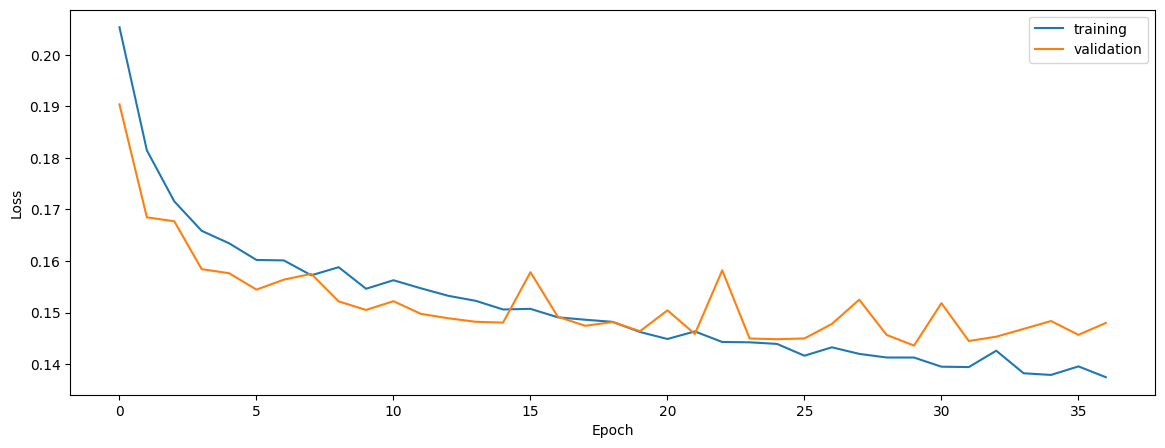

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.6694896950338429
0.6699386833046471
0.6313751581519131


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6680059946771402
0.66321927604797
0.6334091339776388


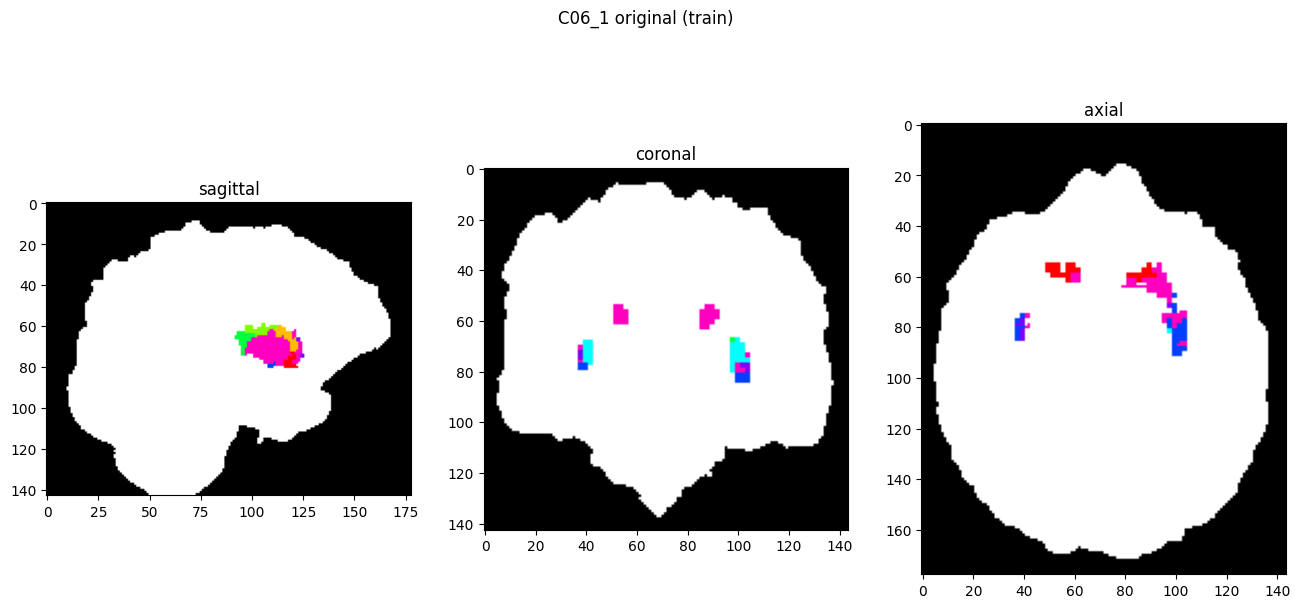

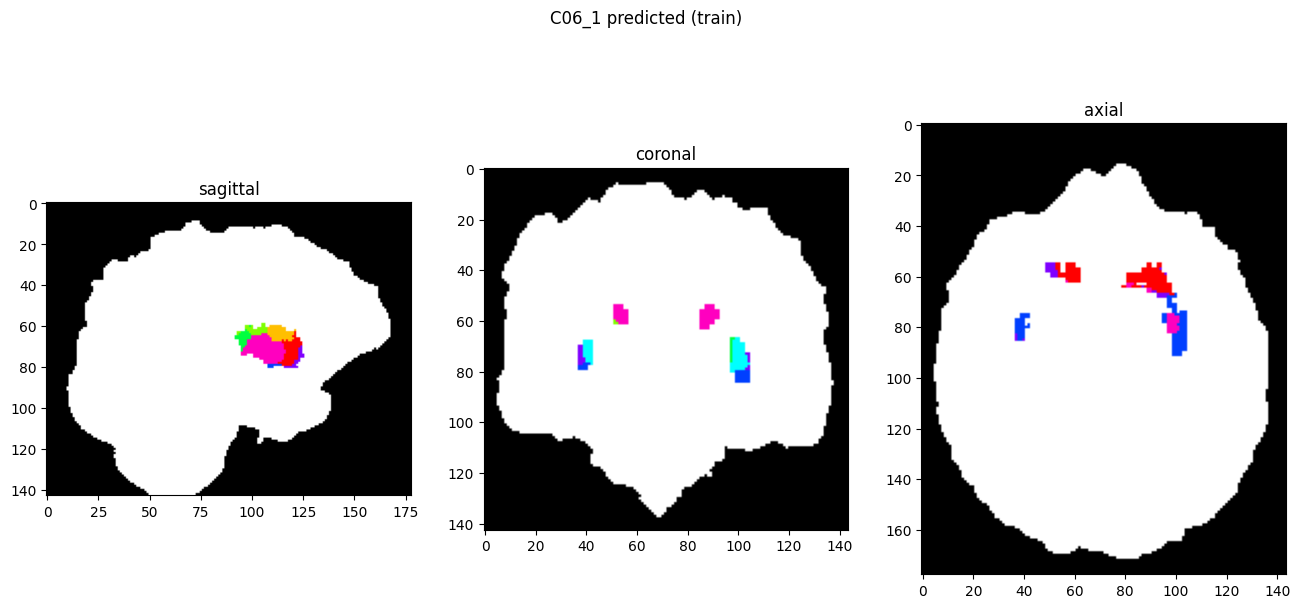

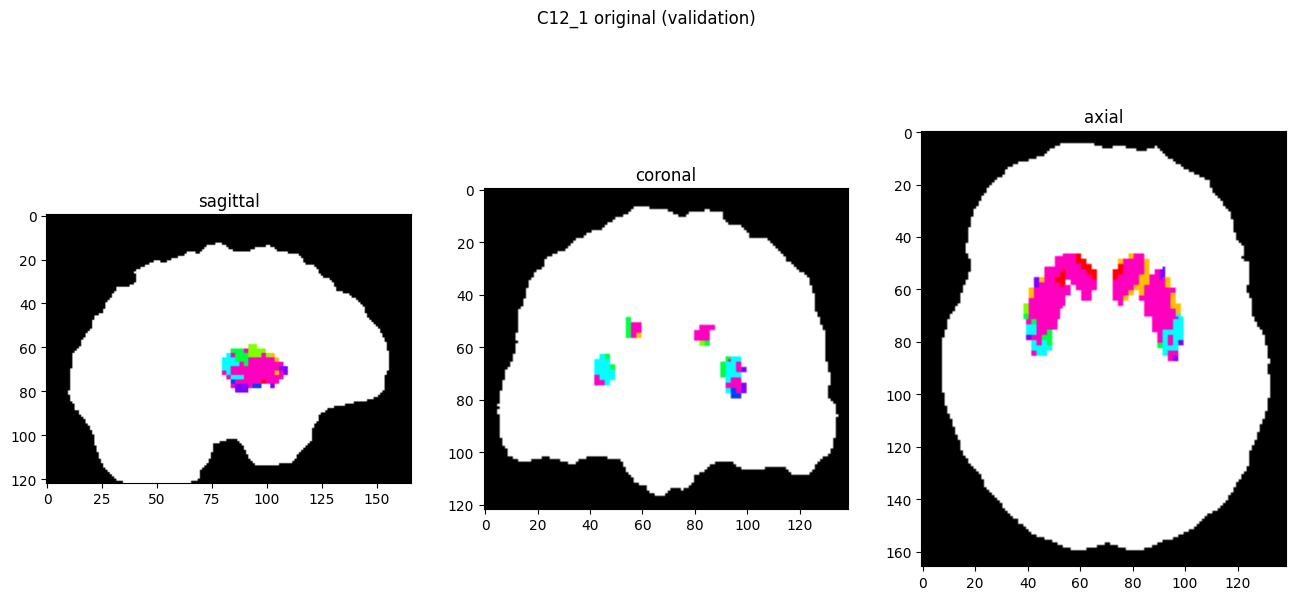

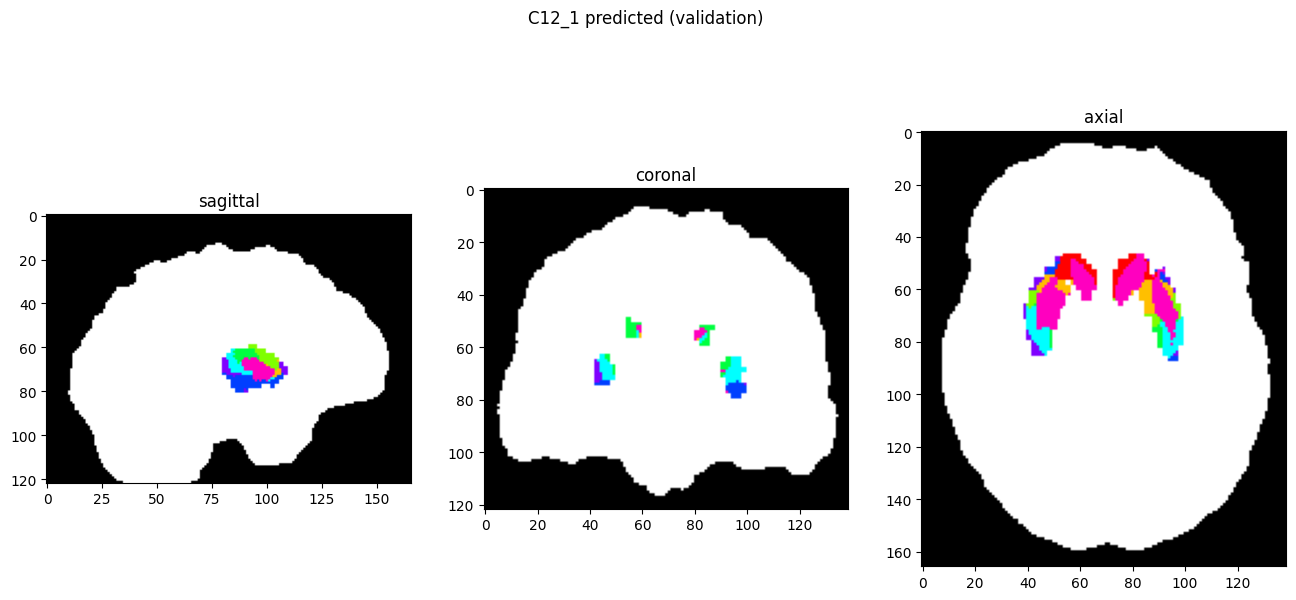

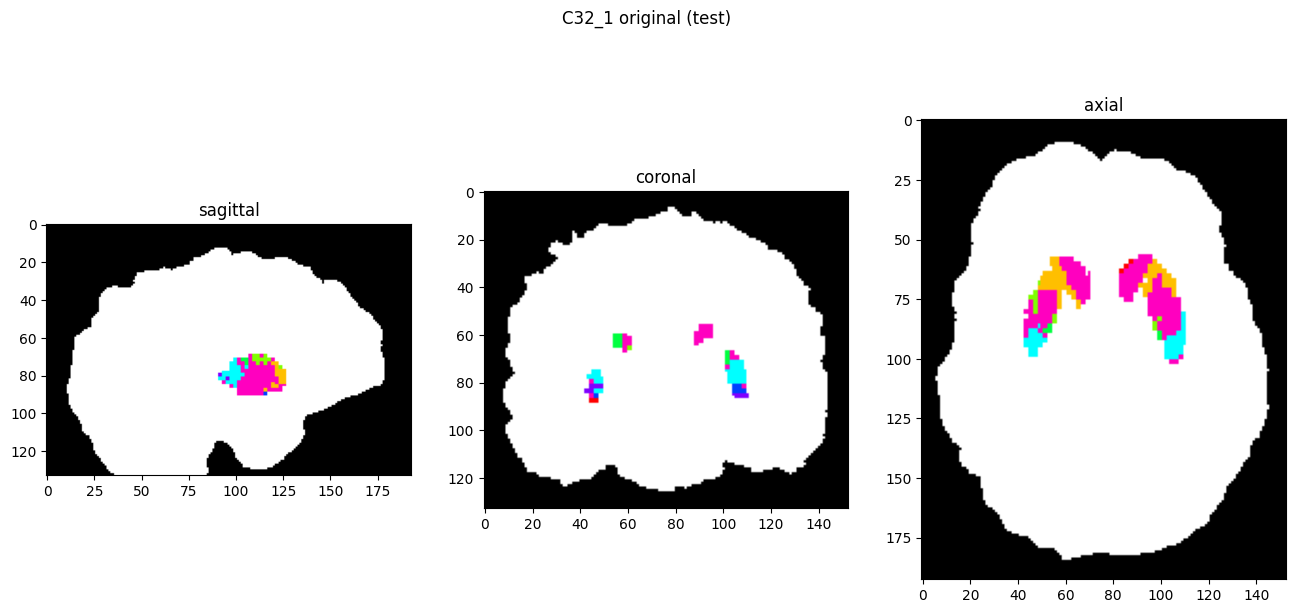

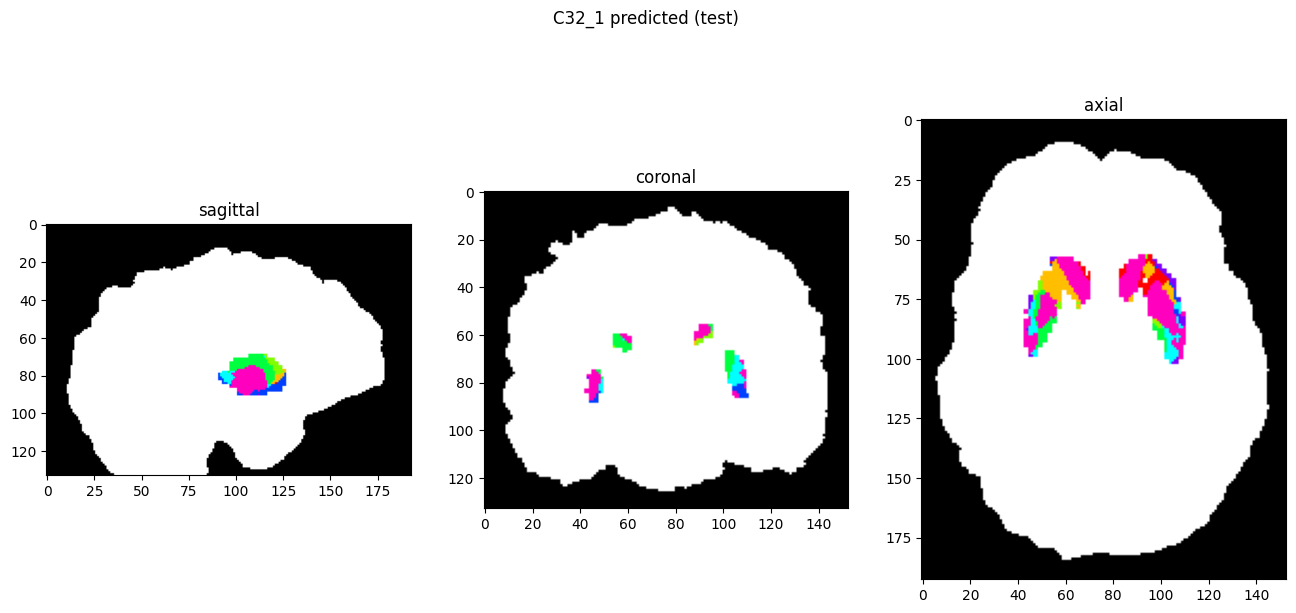

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)